# **Spatial-Spectral Summarizer Fusion Network (S³F-Net) Explainability Analysis**

This notebook contains the full implementation of **S³F-Net** Explainability Analysis on all the datasets utilized. We analyzed the contribution of each branch (spatial and spectral) using L2 Norm and also our custom **Balanced Contribution Score**. The final vector representations from each branch were used to perform the analysis.

## **Chest XRay (Pneumonia)**

In [ ]:
# ==============================================================================
# BLOCK 1: SETUP AND CONFIGURATION
# ==============================================================================

import os
import cv2
import zipfile
import numpy as np
import pandas as pd
import tensorflow as tf
from google.colab import drive
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

print("--- Mounting Google Drive ---")
drive.mount('/content/drive')

# --- Configuration ---

# 1. Choose the dataset the model was trained on ("HAM10000", "BRISC2025", "BUSI", or "ChestXRay")
DATASET_TO_EVALUATE = "ChestXRay"

# 2. Providing the full path to the saved .keras model file.
MODEL_TO_EVALUATE_PATH = "/content/drive/MyDrive/S3F_Net_Models/Concatenation_S3f_net_SN1_XRAY.keras"

# 3. Providing the paths to the dataset ZIP files
ZIP_PATH_HAM10000 = "/content/drive/MyDrive/Medical Image Segmentation/HAM10000.zip"
ZIP_PATH_BRISC2025 = "/content/drive/MyDrive/Medical Image Segmentation/BRISC 2025 Dataset.zip"
ZIP_PATH_BUSI = "/content/drive/MyDrive/Medical Image Segmentation/Breast Ultrasound Images.zip"
ZIP_PATH_XRAY = "/content/drive/MyDrive/Medical Image Segmentation/chest_xray.zip"

# --- Static Config ---
RANDOM_STATE = 42

--- Mounting Google Drive ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ==============================================================================
# BLOCK 2: DATA PREPARATION
# ==============================================================================
# This block unzips and loads the appropriate test set (images and labels)
# for the selected model.

# --- Unzip Logic ---
TEMP_DATA_DIR = f"/content/{DATASET_TO_EVALUATE}_temp"

# --- Assign correct ZIP Path and a DEFINED Base Path ---
if DATASET_TO_EVALUATE == "HAM10000":
    ZIP_PATH = ZIP_PATH_HAM10000
    # Defines the base path to the unzipped HAM10000 data
    DATASET_BASE_PATH = os.path.join(TEMP_DATA_DIR, "HAM10000 Dataset")
elif DATASET_TO_EVALUATE == "BRISC2025":
    ZIP_PATH = ZIP_PATH_BRISC2025
    # Defines the base path to the unzipped BRISC data
    DATASET_BASE_PATH = os.path.join(TEMP_DATA_DIR, "brisc2025/classification_task")
elif DATASET_TO_EVALUATE == "BUSI":
    ZIP_PATH = ZIP_PATH_BUSI
    # Defines the base path to the unzipped BUSI data
    DATASET_BASE_PATH = os.path.join(TEMP_DATA_DIR, "Dataset_BUSI_with_GT")
elif DATASET_TO_EVALUATE == "ChestXRay":
    ZIP_PATH = ZIP_PATH_XRAY
    # Defines the base path to the unzipped Chest X-Ray data
    DATASET_BASE_PATH = os.path.join(TEMP_DATA_DIR, "chest_xray")
else:
    raise ValueError("Invalid DATASET_TO_EVALUATE. Choose from 'HAM10000', 'BRISC2025', 'BUSI', or 'ChestXRay'.")

# --- Unzip Logic ---
if not os.path.exists(TEMP_DATA_DIR):
    print(f"\n--- Unzipping {DATASET_TO_EVALUATE} dataset... ---")
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(TEMP_DATA_DIR)
    print("--- Unzipping complete! ---")
else:
    print(f"\n--- {DATASET_TO_EVALUATE} dataset already unzipped. ---")


# --- Data loading functions that return (images, labels, class_names) ---

def load_ham10000_test_set_with_labels(base_path):
    IMG_SIZE = (225, 300) # Corrected from your previous code
    csv_path = os.path.join(base_path, 'Test_GroundTruth.csv')
    image_dir = os.path.join(base_path, 'Test_images')
    df = pd.read_csv(csv_path)
    class_names = list(df.columns[1:])
    labels_one_hot = df.iloc[:, 1:].values
    labels_int = np.argmax(labels_one_hot, axis=1)
    images, image_ids = [], df['image'].values
    print(f"Loading {len(image_ids)} HAM10000 test images...")
    for img_id in image_ids:
        img_path = os.path.join(image_dir, f"{img_id}.jpg")
        img = cv2.imread(img_path); img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE[1], IMG_SIZE[0]))
        img = img.astype('float32') / 255.0; images.append(img)
    return np.array(images), np.array(labels_int), class_names

def load_brisc_test_set_with_labels(folder_path):
    IMG_SIZE = (256, 256)
    images, labels = [], []
    class_names = sorted(os.listdir(folder_path))
    class_map = {name: i for i, name in enumerate(class_names)}
    print(f"Loading BRISC2025 test images from: {folder_path}")
    for class_name in class_names:
        class_path = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_path): continue
        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, IMG_SIZE)
            img = img.astype('float32') / 255.0
            images.append(img[..., np.newaxis])
            labels.append(class_map[class_name])
    return np.array(images), np.array(labels), class_names

def load_xray_test_set_with_labels(folder_path):
    IMG_SIZE = (384, 512) # Corrected from your previous code
    images, labels = [], []
    class_names = ['NORMAL', 'PNEUMONIA']
    class_map = {name: i for i, name in enumerate(class_names)}
    print(f"Loading Chest X-Ray test images from: {folder_path}")
    for class_name in class_names:
        class_path = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_path): continue
        for filename in os.listdir(class_path):
            if not filename.lower().endswith(('.jpeg', '.jpg', '.png')): continue
            img_path = os.path.join(class_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (IMG_SIZE[1], IMG_SIZE[0]))
            img = img.astype('float32') / 255.0
            images.append(img[..., np.newaxis])
            labels.append(class_map[class_name])
    return np.array(images), np.array(labels), class_names

def load_busi_full_dataset(dataset_path):
    IMG_SIZE = (256, 256)
    categories = ['benign', 'malignant', 'normal']
    images, labels = [], []
    print(f"Loading full BUSI dataset from: {dataset_path}")
    for class_idx, category in enumerate(categories):
        category_path = os.path.join(dataset_path, category)
        if not os.path.exists(category_path) or not os.path.isdir(category_path): continue
        for filename in os.listdir(category_path):
            if '_mask' in filename or not filename.lower().endswith('.png'): continue
            img_path = os.path.join(category_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, IMG_SIZE)
            img = img.astype('float32') / 255.0
            images.append(img[..., np.newaxis])
            labels.append(class_idx)
    return np.array(images), np.array(labels), categories

# --- Loading the correct test set with labels ---
print("\n--- Loading Test Data with Labels ---")
if DATASET_TO_EVALUATE == "HAM10000":
    X_test, y_test, CLASS_NAMES = load_ham10000_test_set_with_labels(DATASET_BASE_PATH)
elif DATASET_TO_EVALUATE == "BRISC2025":
    X_test, y_test, CLASS_NAMES = load_brisc_test_set_with_labels(os.path.join(DATASET_BASE_PATH, "test"))
elif DATASET_TO_EVALUATE == "BUSI":
    images, labels, CLASS_NAMES = load_busi_full_dataset(DATASET_BASE_PATH)
    _, X_test, _, y_test = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state=RANDOM_STATE)
elif DATASET_TO_EVALUATE == "ChestXRay":
    X_test, y_test, CLASS_NAMES = load_xray_test_set_with_labels(os.path.join(DATASET_BASE_PATH, "test"))

# --- Final Checks ---
print(f"\nLoaded {len(X_test)} test samples and {len(y_test)} test labels.")
print(f"Dataset: {DATASET_TO_EVALUATE}")
print(f"Class Names: {CLASS_NAMES}")
num_classes = len(CLASS_NAMES)


--- Unzipping ChestXRay dataset... ---
--- Unzipping complete! ---

--- Loading Test Data with Labels ---
Loading Chest X-Ray test images from: /content/ChestXRay_temp/chest_xray/test

Loaded 624 test samples and 624 test labels.
Dataset: ChestXRay
Class Names: ['NORMAL', 'PNEUMONIA']


In [ ]:
# ==============================================================================
# BLOCK 3: MODEL RE-CREATION FOR EXPLAINABILITY
# ==============================================================================
# This block re-creates the S³F-Net architecture and modifies it to output
# the intermediate feature vectors we need to analyze.

# --- Custom SpectralFilter Layer & Encoders ---
class SpectralFilterLayer(layers.Layer):
    def __init__(self, filters, **kwargs): super().__init__(**kwargs); self.filters = filters
    def build(self, input_shape):
        _, h, w, c = input_shape
        fft_shape = (h, w // 2 + 1)
        self.real_weights = self.add_weight(name='real_weights', shape=(c, self.filters, *fft_shape), initializer='glorot_uniform')
        self.imag_weights = self.add_weight(name='imag_weights', shape=(c, self.filters, *fft_shape), initializer='glorot_uniform')
        self.bias = self.add_weight(name='bias', shape=(self.filters,), initializer='zeros')
    def call(self, inputs):
        inputs_p = tf.transpose(inputs, [0, 3, 1, 2])
        inputs_fft = tf.signal.rfft2d(inputs_p)
        kernel_fft = tf.complex(self.real_weights, self.imag_weights)
        output_fft = tf.einsum('bchw,cfhw->bfhw', inputs_fft, kernel_fft)
        output_s = tf.signal.irfft2d(output_fft)
        output_p = tf.transpose(output_s, [0, 2, 3, 1])
        return output_p + self.bias
    def get_config(self):
        config = super().get_config()
        config.update({"filters": self.filters})
        return config

def build_spatial_encoder(inputs):
    x = inputs
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(32, 3, padding='same')(x); x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, 3, padding='same')(x); x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(128, 3, padding='same')(x); x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, 3, padding='same')(x); x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.4)(x)
    return x

def depthwise_sep_block(x, filters, kernel_size=3, strides=1):
    x = layers.DepthwiseConv2D(kernel_size, strides=strides, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, 1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    return x

def build_spectral_summary_branch(inputs):
    x = SpectralFilterLayer(32)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Uncomment for SpectraNet-2 variations
    # x = SpectralFilterLayer(64)(x)
    # x = layers.BatchNormalization()(x)
    # x = layers.ReLU()(x)

    # Uncomment for SpectraNet-1 variations
    x = depthwise_sep_block(x, 64)
    x = layers.MaxPooling2D(2)(x)

    x = depthwise_sep_block(x, 128)
    x = layers.MaxPooling2D(2)(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(16, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1875)(x)
    x = layers.Dense(4, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3125)(x)

    return x

# --- Explainable Model Builder ---
def build_s3f_net_explainable(input_shape, num_classes):
    """Builds the S³F-Net but also outputs the intermediate branch vectors."""
    inputs = layers.Input(input_shape)

    # Tower 1: Deep Spatial Branch
    spatial_features = build_spatial_encoder(inputs)
    spatial_vector_raw = layers.GlobalAveragePooling2D()(spatial_features)
    spatial_refined = layers.Dense(512, activation='relu', name='fc_spatial')(spatial_vector_raw)
    spatial_refined = layers.BatchNormalization()(spatial_refined)
    spatial_refined = layers.Dropout(0.5)(spatial_refined)

    # Tower 2: Spectral Summary Branch
    spectral_summary_vector = build_spectral_summary_branch(inputs)

    # Fusion
    fused_vector = layers.concatenate([spatial_refined, spectral_summary_vector])
    outputs = layers.Dense(num_classes, activation='sigmoid')(fused_vector)

    # Model with Multiple Outputs
    model = models.Model(
        inputs=inputs,
        outputs=[outputs, spatial_refined, spectral_summary_vector],
        name="Explainable_S3F_Net"
    )
    return model

# Instantiating the explainable model
if DATASET_TO_EVALUATE == "HAM10000":
    num_classes = 7
elif DATASET_TO_EVALUATE == "BRISC2025":
    num_classes = 4
elif DATASET_TO_EVALUATE == "BUSI":
    num_classes = 3
elif DATASET_TO_EVALUATE == "ChestXRay":
    num_classes = 1          # If Sigmoid --> 1, Else if Softmax --> 2

explainable_model = build_s3f_net_explainable(X_test.shape[1:], num_classes=num_classes)

# --- Loading the weights from our trained model ---
print(f"\n--- Loading weights from: {MODEL_TO_EVALUATE_PATH} ---")
explainable_model.load_weights(MODEL_TO_EVALUATE_PATH)
print("Weights loaded successfully.")


--- Loading weights from: /content/drive/MyDrive/S2F_Net_Models/Concatenation_S3f_net_SN1_XRAY.keras ---
Weights loaded successfully.


In [ ]:
# ==============================================================================
# BLOCK 4: Loading Results
# ==============================================================================
print("\n--- Generating predictions and extracting branch vectors ---")
results = explainable_model.predict(X_test)
y_pred_proba, spatial_vectors, spectral_vectors = results[0], results[1], results[2]



--- Generating predictions and extracting branch vectors ---
20/20 ━━━━━━━━━━━━━━━━━━━━ 479s 24s/step


## **Using L2 Norm**


    BRANCH CONTRIBUTION ANALYSIS (ChestXRay)
Overall Average Spatial Branch Contribution:  83.62%
Overall Average Spectral Branch Contribution: 16.38%
------------------------------------------------------------
Per-Class Average Contributions:
            Spatial Contribution  Spectral Contribution
True Label                                             
NORMAL                    91.61%                  8.39%
PNEUMONIA                 78.83%                 21.17%



/tmp/ipython-input-2929078036.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Spatial Branch', 'Spectral Branch'], y=[avg_spatial_contrib, avg_spectral_contrib], palette=[palette[0], palette[1]])


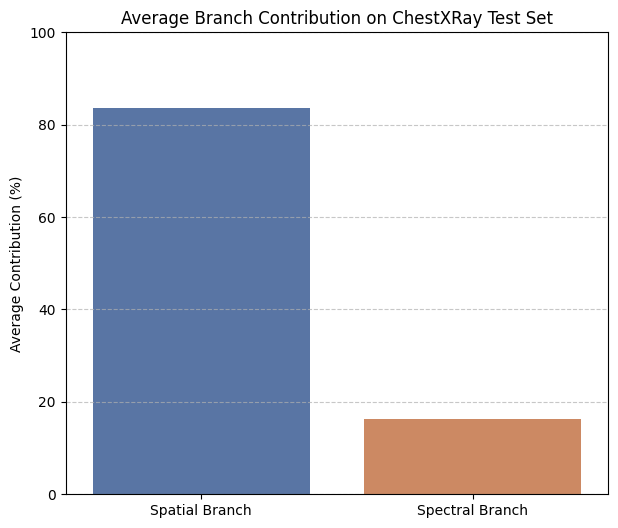


--- Generating Combined Distribution Plot (All Filled) ---


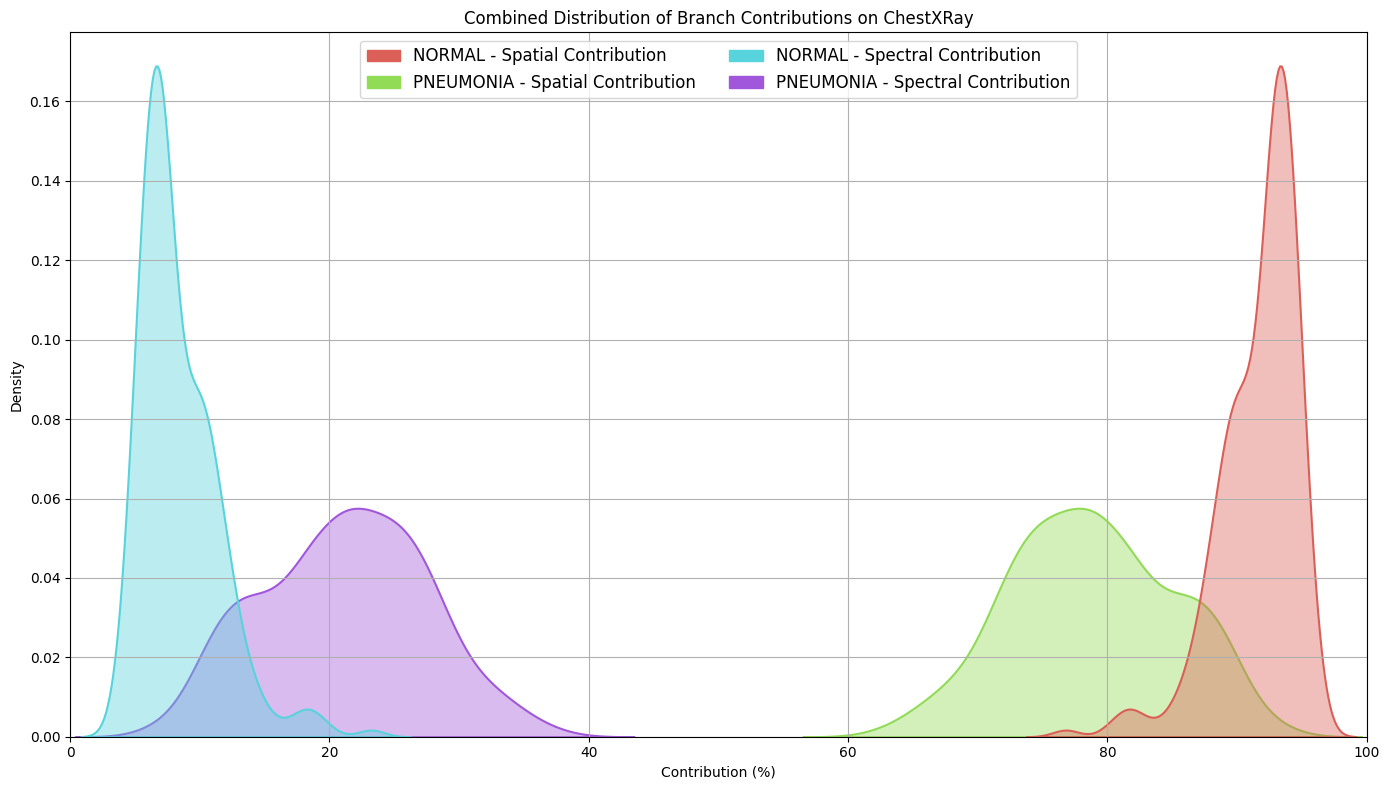


--- Generating Per-Class Distribution Plots ---


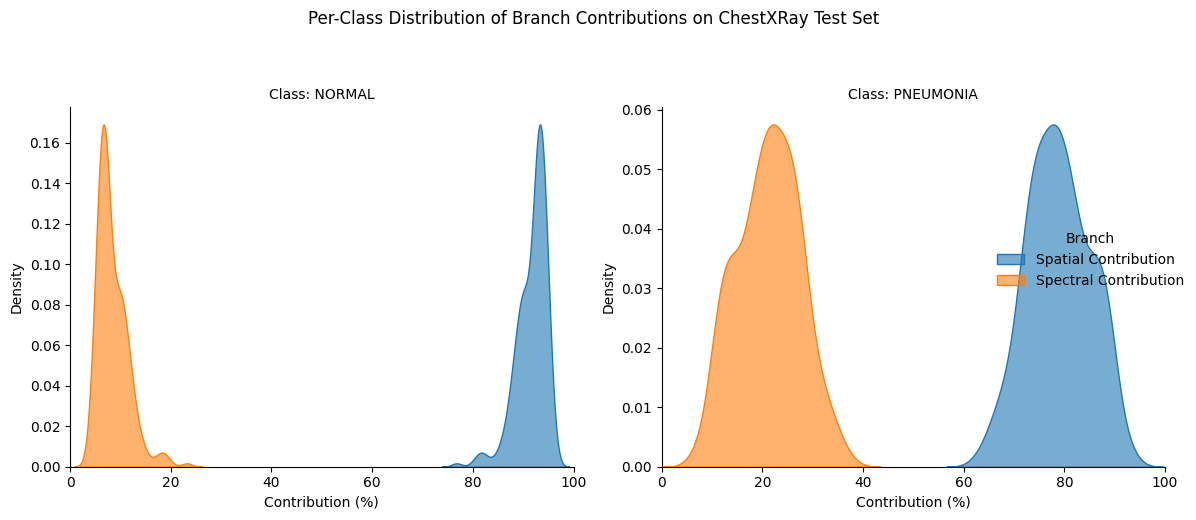

In [ ]:
# ============================================
# BLOCK 5: ANALYSIS AND VISUALIZATION
# ============================================

# --- Calculating L2 Norms and Contributions ---
spatial_norms = np.linalg.norm(spatial_vectors, axis=1)
spectral_norms = np.linalg.norm(spectral_vectors, axis=1)
total_norms = spatial_norms + spectral_norms; total_norms[total_norms == 0] = 1e-6
spatial_contribution = (spatial_norms / total_norms) * 100
spectral_contribution = (spectral_norms / total_norms) * 100

# --- Preparing DataFrame for all analyses ---
df_contrib = pd.DataFrame({
    'Spatial Contribution': spatial_contribution,
    'Spectral Contribution': spectral_contribution,
    'True Label': [CLASS_NAMES[i] for i in y_test.flatten()]
})

# Melted DataFrame for distribution plots
df_melted = df_contrib.melt(
    id_vars=['True Label'],
    value_vars=['Spatial Contribution', 'Spectral Contribution'],
    var_name='Branch',
    value_name='Contribution (%)'
)

# --- Overall and Per-Class Average Contributions ---
avg_spatial_contrib = df_contrib['Spatial Contribution'].mean()
avg_spectral_contrib = df_contrib['Spectral Contribution'].mean()
print("\n" + "="*60); print(f"    BRANCH CONTRIBUTION ANALYSIS ({DATASET_TO_EVALUATE})"); print("="*60)
print(f"Overall Average Spatial Branch Contribution:  {avg_spatial_contrib:.2f}%")
print(f"Overall Average Spectral Branch Contribution: {avg_spectral_contrib:.2f}%")
print("-" * 60)
print("Per-Class Average Contributions:")
class_wise_avg = df_contrib.groupby('True Label').mean()
print(class_wise_avg.to_string(float_format="%.2f%%"))
print("="*60 + "\n")

# --- Visualize the Results ---

# 1. Bar Chart for the Overall Average
plt.figure(figsize=(7, 6))
palette = sns.color_palette("deep")
sns.barplot(x=['Spatial Branch', 'Spectral Branch'], y=[avg_spatial_contrib, avg_spectral_contrib], palette=[palette[0], palette[1]])
plt.ylabel("Average Contribution (%)")
plt.title(f"Average Branch Contribution on {DATASET_TO_EVALUATE} Test Set")
plt.ylim(0, 100); plt.grid(axis='y', linestyle='--', alpha=0.7); plt.show()

# --- COMBINED DISTRIBUTION PLOT ---
import matplotlib.patches as mpatches

print("\n--- Generating Combined Distribution Plot (All Filled) ---")
plt.figure(figsize=(14, 8))
ax = plt.gca() # Getting the current axes

# Creating a unique color for each combination of "True Label" and "Branch"
num_labels = len(df_melted['True Label'].unique())
num_branches = len(df_melted['Branch'].unique())
palette = sns.color_palette("hls", n_colors=num_labels * num_branches)

# Creating a new column that combines the class and branch for the hue mapping
df_melted['Hue Category'] = df_melted['True Label'].str.cat(df_melted['Branch'], sep=' - ')

# Plotting the KDE using the new combined category for the color
sns.kdeplot(
    data=df_melted,
    x="Contribution (%)",
    hue="Hue Category",
    fill=True,
    alpha=0.4,
    linewidth=1.5,
    common_norm=False,
    palette=palette,
    ax=ax,
    legend=False
)

# 1. Geting the unique categories and their corresponding colors
hue_categories = df_melted['Hue Category'].unique()
colors = palette[:len(hue_categories)] # Use the same colors sns used

# 2. Creating a list of "patches" for the legend
legend_patches = [mpatches.Patch(color=color, label=label)
                  for label, color in zip(hue_categories, colors)]

# Creating the legend manually and place it INSIDE the grid at the top center
plt.legend(
    handles=legend_patches,
    #title='Class - Branch',
    loc='upper center',
    ncol=min(4, len(CLASS_NAMES)), # Arranging in columns for a compact fit
    fontsize='large'
)


plt.title(f"Combined Distribution of Branch Contributions on {DATASET_TO_EVALUATE}")
plt.grid(True)
plt.xlim(0, 100)
plt.tight_layout()
plt.show()

# --- CLASS-WISE SEPARATE PLOTS ---
# 3. Preparing a melted DataFrame for the FacetGrid plot
print("\n--- Generating Per-Class Distribution Plots ---")
df_melted = df_contrib.melt(
    id_vars=['True Label'],
    value_vars=['Spatial Contribution', 'Spectral Contribution'],
    var_name='Branch',
    value_name='Contribution (%)'
)
# 4. Creating the separate, per-class distribution plots
g = sns.FacetGrid(
    df_melted, col="True Label", hue="Branch", col_wrap=min(4, len(CLASS_NAMES)),
    height=5, sharex=True, sharey=False
)
g.map(sns.kdeplot, "Contribution (%)", fill=True, alpha=0.6, common_norm=False)
g.add_legend()
g.fig.suptitle(f'Per-Class Distribution of Branch Contributions on {DATASET_TO_EVALUATE} Test Set', y=1.03)
g.set(xlim=(0, 100))
g.set_titles("Class: {col_name}")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

## **Using the proposed *Balanced Contribution Score***


    BALANCED BRANCH CONTRIBUTION ANALYSIS (ChestXRay)
Average Spatial Branch Contribution:  35.42%
Average Spectral Branch Contribution: 64.58%
------------------------------------------------------------
Per-Class Average Contributions:
            Spatial Contribution (%)  Spectral Contribution (%)
True Label                                                     
NORMAL                        50.52%                     49.48%
PNEUMONIA                     26.36%                     73.64%



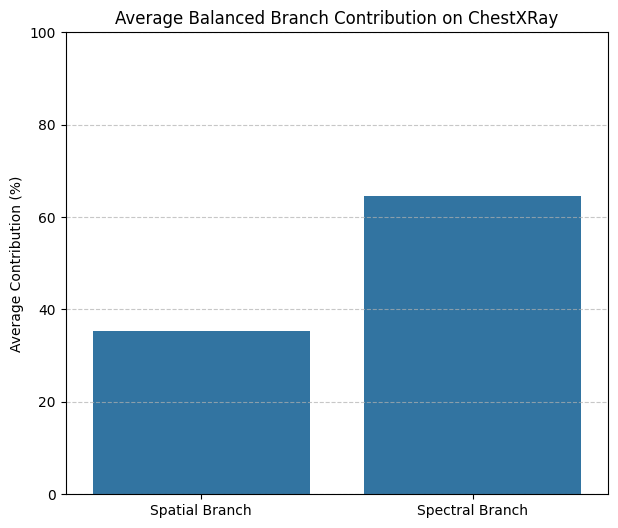


--- Generating Combined Distribution Plot (All Filled) ---


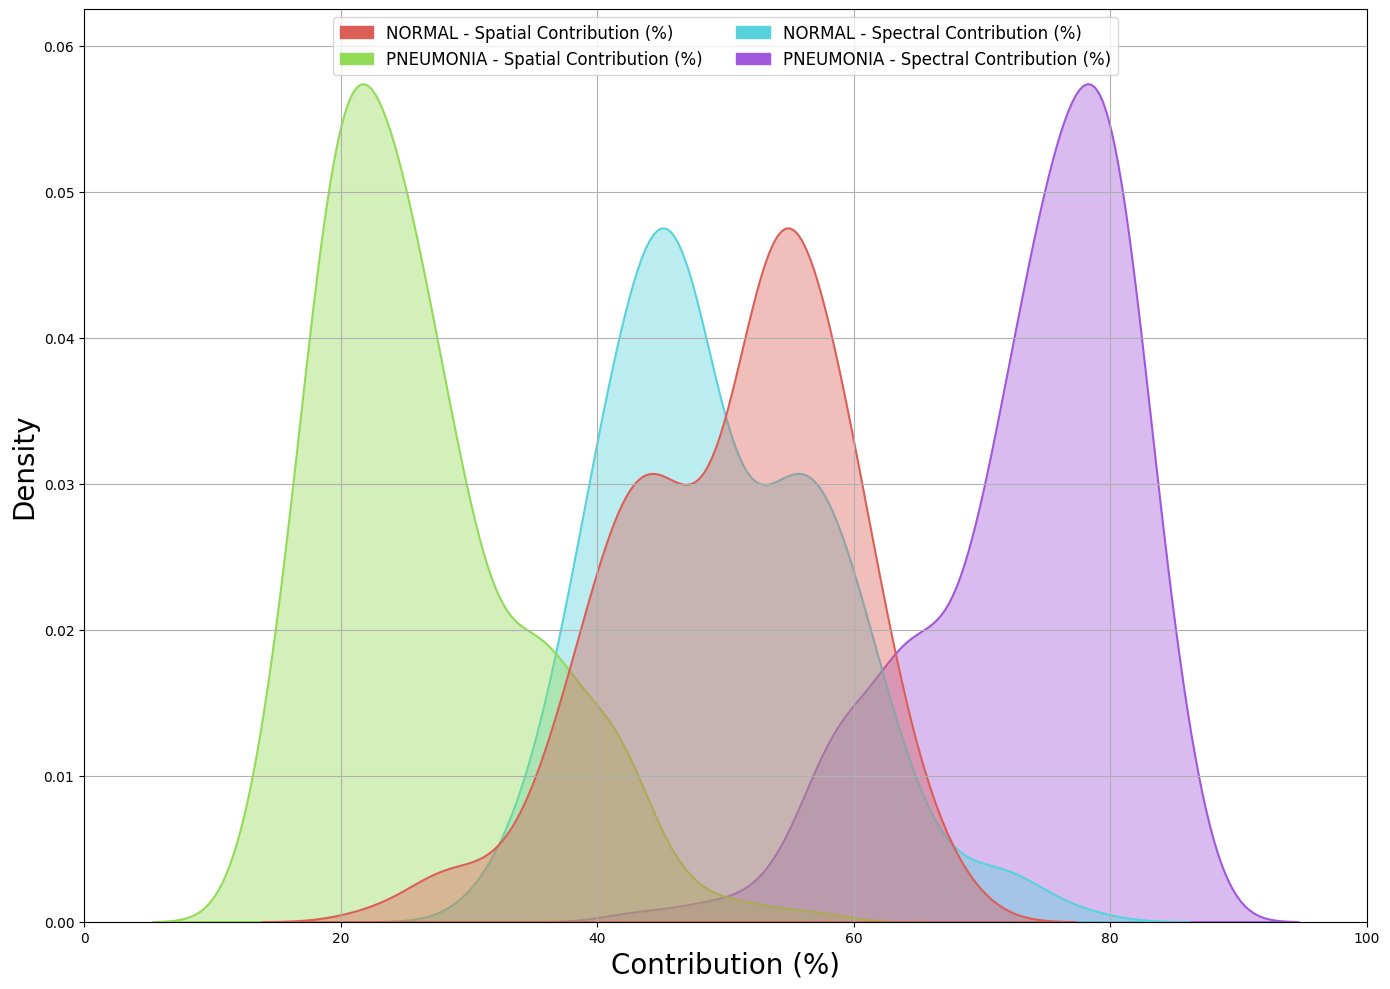

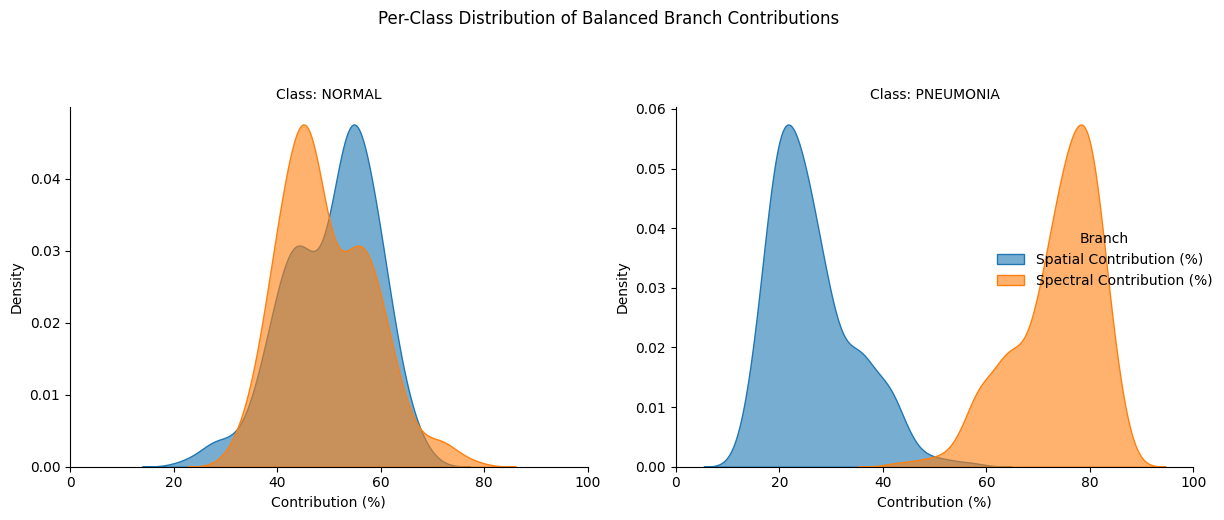

In [ ]:
# --- 1. Calculating Component Metrics ---
# Total Magnitude (L2 Norm)
spatial_total_mag = np.linalg.norm(spatial_vectors, axis=1)
spectral_total_mag = np.linalg.norm(spectral_vectors, axis=1)

# Per-Feature Magnitude
spatial_dim = spatial_vectors.shape[1]
spectral_dim = spectral_vectors.shape[1]
spatial_per_feature_mag = spatial_total_mag / spatial_dim
spectral_per_feature_mag = spectral_total_mag / spectral_dim

# --- 2. Calculating the Balanced Contribution Score ---
# Geometric Mean of the two magnitudes
spatial_score = np.sqrt(spatial_total_mag * spatial_per_feature_mag)
spectral_score = np.sqrt(spectral_total_mag * spectral_per_feature_mag)

# --- 3. Calculate Percentage Contributions based on the new score ---
total_score = spatial_score + spectral_score
total_score[total_score == 0] = 1e-6 # To avoid division by zero

spatial_contribution_pct = (spatial_score / total_score) * 100
spectral_contribution_pct = (spectral_score / total_score) * 100

# --- 4. Reporting the Averages ---
avg_spatial_contrib = np.mean(spatial_contribution_pct)
avg_spectral_contrib = np.mean(spectral_contribution_pct)

print("\n" + "="*60)
print(f"    BALANCED BRANCH CONTRIBUTION ANALYSIS ({DATASET_TO_EVALUATE})")
print("="*60)
print(f"Average Spatial Branch Contribution:  {avg_spatial_contrib:.2f}%")
print(f"Average Spectral Branch Contribution: {avg_spectral_contrib:.2f}%")
print("-" * 60)

# --- 5. Per-Class Reporting ---
df_contrib = pd.DataFrame({
    'Spatial Contribution (%)': spatial_contribution_pct,
    'Spectral Contribution (%)': spectral_contribution_pct,
    'True Label': [CLASS_NAMES[i] for i in y_test.flatten()]
})
print("Per-Class Average Contributions:")
class_wise_avg = df_contrib.groupby('True Label').mean()
print(class_wise_avg.to_string(float_format="%.2f%%"))
print("="*60 + "\n")

# Melted DataFrame for distribution plots
df_melted = df_contrib.melt(
    id_vars=['True Label'],
    value_vars=['Spatial Contribution (%)', 'Spectral Contribution (%)'],
    var_name='Branch',
    value_name='Contribution (%)'
)

# --- 6. Visualizing the Results ---

# Bar Chart for the Average
plt.figure(figsize=(7, 6))
sns.barplot(x=['Spatial Branch', 'Spectral Branch'], y=[avg_spatial_contrib, avg_spectral_contrib])
plt.ylabel("Average Contribution (%)")
plt.title(f"Average Balanced Branch Contribution on {DATASET_TO_EVALUATE}")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# --- COMBINED DISTRIBUTION PLOT ---
import matplotlib.patches as mpatches

print("\n--- Generating Combined Distribution Plot (All Filled) ---")
plt.figure(figsize=(14, 8))
ax = plt.gca() # Get the current axes

num_labels = len(df_melted['True Label'].unique())
num_branches = len(df_melted['Branch'].unique())
palette = sns.color_palette("hls", n_colors=num_labels * num_branches)

# Creating a new column that combines the class and branch for the hue mapping
df_melted['Hue Category'] = df_melted['True Label'].str.cat(df_melted['Branch'], sep=' - ')

# Plotting the KDE using the new combined category for the color
sns.kdeplot(
    data=df_melted,
    x="Contribution (%)",
    hue="Hue Category",
    fill=True,
    alpha=0.4,
    linewidth=1.5,
    common_norm=False,
    palette=palette,
    ax=ax,
    legend=False
)

plt.xlabel("Contribution (%)", fontsize=20)
plt.ylabel("Density", fontsize=20)

# Getting the unique categories and their corresponding colors
hue_categories = df_melted['Hue Category'].unique()
colors = palette[:len(hue_categories)]

# Creating a list of patches for the legend
legend_patches = [mpatches.Patch(color=color, label=label)
                  for label, color in zip(hue_categories, colors)]

# Creating the legend manually and placing it INSIDE the grid at the top center
plt.legend(
    handles=legend_patches,
    #title='Class - Branch',
    loc='upper center',
    ncol=min(4, len(CLASS_NAMES)),
    fontsize='large'
)


#plt.title(f"Combined Distribution of Branch Contributions on {DATASET_TO_EVALUATE}")
plt.grid(True)
plt.xlim(0, 100)
plt.ylim(0.00, 0.0625)
plt.tight_layout()
plt.show()

# Per-Class Distribution Plot
df_melted = df_contrib.melt(
    id_vars=['True Label'],
    value_vars=['Spatial Contribution (%)', 'Spectral Contribution (%)'],
    var_name='Branch',
    value_name='Contribution (%)'
)
g = sns.FacetGrid(df_melted, col="True Label", hue="Branch", col_wrap=min(4, len(CLASS_NAMES)), height=5, sharex=True, sharey=False)
g.map(sns.kdeplot, "Contribution (%)", fill=True, alpha=0.6, common_norm=False)
g.add_legend()
g.fig.suptitle(f'Per-Class Distribution of Balanced Branch Contributions', y=1.03)
g.set(xlim=(0, 100)); g.set_titles("Class: {col_name}"); plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# **HAM10000**

In [ ]:
# ==============================================================================
# BLOCK 1: SETUP AND CONFIGURATION
# ==============================================================================

# 1. Choosing the dataset the model was trained on ("HAM10000", "BRISC2025", "BUSI", or "ChestXRay")
DATASET_TO_EVALUATE = "HAM10000"

# 2. Providing the full path to the saved .keras model
MODEL_TO_EVALUATE_PATH = "/content/drive/MyDrive/S3F_Net_Models/efficient_summarizer_weighted_f1.keras"

--- Mounting Google Drive ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ==============================================================================
# BLOCK 2: DATA PREPARATION
# ==============================================================================
# This block unzips and loads the appropriate test set (images and labels)
# for the selected model.

# --- Unzip Logic ---
TEMP_DATA_DIR = f"/content/{DATASET_TO_EVALUATE}_temp"

# --- Assign correct ZIP Path and a DEFINED Base Path ---
if DATASET_TO_EVALUATE == "HAM10000":
    ZIP_PATH = ZIP_PATH_HAM10000
    # Defines the base path to the unzipped HAM10000 data
    DATASET_BASE_PATH = os.path.join(TEMP_DATA_DIR, "HAM10000 Dataset")
elif DATASET_TO_EVALUATE == "BRISC2025":
    ZIP_PATH = ZIP_PATH_BRISC2025
    # Defines the base path to the unzipped BRISC data
    DATASET_BASE_PATH = os.path.join(TEMP_DATA_DIR, "brisc2025/classification_task")
elif DATASET_TO_EVALUATE == "BUSI":
    ZIP_PATH = ZIP_PATH_BUSI
    # Defines the base path to the unzipped BUSI data
    DATASET_BASE_PATH = os.path.join(TEMP_DATA_DIR, "Dataset_BUSI_with_GT")
elif DATASET_TO_EVALUATE == "ChestXRay":
    ZIP_PATH = ZIP_PATH_XRAY
    # Defines the base path to the unzipped Chest X-Ray data
    DATASET_BASE_PATH = os.path.join(TEMP_DATA_DIR, "chest_xray")
else:
    raise ValueError("Invalid DATASET_TO_EVALUATE. Choose from 'HAM10000', 'BRISC2025', 'BUSI', or 'ChestXRay'.")

# --- Unzip Logic ---
if not os.path.exists(TEMP_DATA_DIR):
    print(f"\n--- Unzipping {DATASET_TO_EVALUATE} dataset... ---")
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(TEMP_DATA_DIR)
    print("--- Unzipping complete! ---")
else:
    print(f"\n--- {DATASET_TO_EVALUATE} dataset already unzipped. ---")


# --- Data loading functions that return (images, labels, class_names) ---

def load_ham10000_test_set_with_labels(base_path):
    IMG_SIZE = (225, 300) # Corrected from your previous code
    csv_path = os.path.join(base_path, 'Test_GroundTruth.csv')
    image_dir = os.path.join(base_path, 'Test_images')
    df = pd.read_csv(csv_path)
    class_names = list(df.columns[1:])
    labels_one_hot = df.iloc[:, 1:].values
    labels_int = np.argmax(labels_one_hot, axis=1)
    images, image_ids = [], df['image'].values
    print(f"Loading {len(image_ids)} HAM10000 test images...")
    for img_id in image_ids:
        img_path = os.path.join(image_dir, f"{img_id}.jpg")
        img = cv2.imread(img_path); img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE[1], IMG_SIZE[0]))
        img = img.astype('float32') / 255.0; images.append(img)
    return np.array(images), np.array(labels_int), class_names

def load_brisc_test_set_with_labels(folder_path):
    IMG_SIZE = (256, 256)
    images, labels = [], []
    class_names = sorted(os.listdir(folder_path))
    class_map = {name: i for i, name in enumerate(class_names)}
    print(f"Loading BRISC2025 test images from: {folder_path}")
    for class_name in class_names:
        class_path = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_path): continue
        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, IMG_SIZE)
            img = img.astype('float32') / 255.0
            images.append(img[..., np.newaxis])
            labels.append(class_map[class_name])
    return np.array(images), np.array(labels), class_names

def load_xray_test_set_with_labels(folder_path):
    IMG_SIZE = (384, 512) # Corrected from your previous code
    images, labels = [], []
    class_names = ['NORMAL', 'PNEUMONIA']
    class_map = {name: i for i, name in enumerate(class_names)}
    print(f"Loading Chest X-Ray test images from: {folder_path}")
    for class_name in class_names:
        class_path = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_path): continue
        for filename in os.listdir(class_path):
            if not filename.lower().endswith(('.jpeg', '.jpg', '.png')): continue
            img_path = os.path.join(class_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (IMG_SIZE[1], IMG_SIZE[0]))
            img = img.astype('float32') / 255.0
            images.append(img[..., np.newaxis])
            labels.append(class_map[class_name])
    return np.array(images), np.array(labels), class_names

def load_busi_full_dataset(dataset_path):
    IMG_SIZE = (256, 256)
    categories = ['benign', 'malignant', 'normal']
    images, labels = [], []
    print(f"Loading full BUSI dataset from: {dataset_path}")
    for class_idx, category in enumerate(categories):
        category_path = os.path.join(dataset_path, category)
        if not os.path.exists(category_path) or not os.path.isdir(category_path): continue
        for filename in os.listdir(category_path):
            if '_mask' in filename or not filename.lower().endswith('.png'): continue
            img_path = os.path.join(category_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, IMG_SIZE)
            img = img.astype('float32') / 255.0
            images.append(img[..., np.newaxis])
            labels.append(class_idx)
    return np.array(images), np.array(labels), categories

# --- Loading the correct test set with labels ---
print("\n--- Loading Test Data with Labels ---")
if DATASET_TO_EVALUATE == "HAM10000":
    X_test, y_test, CLASS_NAMES = load_ham10000_test_set_with_labels(DATASET_BASE_PATH)
elif DATASET_TO_EVALUATE == "BRISC2025":
    X_test, y_test, CLASS_NAMES = load_brisc_test_set_with_labels(os.path.join(DATASET_BASE_PATH, "test"))
elif DATASET_TO_EVALUATE == "BUSI":
    images, labels, CLASS_NAMES = load_busi_full_dataset(DATASET_BASE_PATH)
    _, X_test, _, y_test = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state=RANDOM_STATE)
elif DATASET_TO_EVALUATE == "ChestXRay":
    X_test, y_test, CLASS_NAMES = load_xray_test_set_with_labels(os.path.join(DATASET_BASE_PATH, "test"))

# --- Final Checks ---
print(f"\nLoaded {len(X_test)} test samples and {len(y_test)} test labels.")
print(f"Dataset: {DATASET_TO_EVALUATE}")
print(f"Class Names: {CLASS_NAMES}")
num_classes = len(CLASS_NAMES)


--- Unzipping HAM10000 dataset... ---
--- Unzipping complete! ---

--- Loading Test Data with Labels ---
Loading 1512 HAM10000 test images...

Loaded 1512 test samples and 1512 test labels.
Dataset: HAM10000
Class Names: ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']


In [ ]:
# ==============================================================================
# BLOCK 3: MODEL RE-CREATION FOR EXPLAINABILITY
# ==============================================================================
# This block re-creates the S³F-Net architecture and modifies it to output
# the intermediate feature vectors we need to analyze.

# --- Custom SpectralFilter Layer & Encoders ---
class SpectralFilterLayer(layers.Layer):
    def __init__(self, filters, **kwargs): super().__init__(**kwargs); self.filters = filters
    def build(self, input_shape):
        _, h, w, c = input_shape
        fft_shape = (h, w // 2 + 1)
        self.real_weights = self.add_weight(name='real_weights', shape=(c, self.filters, *fft_shape), initializer='glorot_uniform')
        self.imag_weights = self.add_weight(name='imag_weights', shape=(c, self.filters, *fft_shape), initializer='glorot_uniform')
        self.bias = self.add_weight(name='bias', shape=(self.filters,), initializer='zeros')
    def call(self, inputs):
        inputs_p = tf.transpose(inputs, [0, 3, 1, 2])
        inputs_fft = tf.signal.rfft2d(inputs_p)
        kernel_fft = tf.complex(self.real_weights, self.imag_weights)
        output_fft = tf.einsum('bchw,cfhw->bfhw', inputs_fft, kernel_fft)
        output_s = tf.signal.irfft2d(output_fft)
        output_p = tf.transpose(output_s, [0, 2, 3, 1])
        return output_p + self.bias
    def get_config(self):
        config = super().get_config()
        config.update({"filters": self.filters})
        return config

def build_spatial_encoder(inputs):
    x = inputs
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(32, 3, padding='same')(x); x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, 3, padding='same')(x); x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(128, 3, padding='same')(x); x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, 3, padding='same')(x); x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.4)(x)
    return x

def depthwise_sep_block(x, filters, kernel_size=3, strides=1):
    x = layers.DepthwiseConv2D(kernel_size, strides=strides, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, 1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    return x

def build_spectral_summary_branch(inputs):
    x = SpectralFilterLayer(32)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Uncomment for SpectraNet-2 variations
    # x = SpectralFilterLayer(64)(x)
    # x = layers.BatchNormalization()(x)
    # x = layers.ReLU()(x)

    # Uncomment for SpectraNet-1 variations
    x = depthwise_sep_block(x, 64)
    x = layers.MaxPooling2D(2)(x)

    x = depthwise_sep_block(x, 128)
    x = layers.MaxPooling2D(2)(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(16, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1875)(x)
    x = layers.Dense(4, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3125)(x)

    return x

# --- Explainable Model Builder ---
def build_s3f_net_explainable(input_shape, num_classes):
    """Builds the S³F-Net but also outputs the intermediate branch vectors."""
    inputs = layers.Input(input_shape)

    # Tower 1: Deep Spatial Branch
    spatial_features = build_spatial_encoder(inputs)
    spatial_vector_raw = layers.GlobalAveragePooling2D()(spatial_features)
    spatial_refined = layers.Dense(512, activation='relu', name='fc_spatial')(spatial_vector_raw)
    spatial_refined = layers.BatchNormalization()(spatial_refined)
    spatial_refined = layers.Dropout(0.5)(spatial_refined)

    # Tower 2: Spectral Summary Branch
    spectral_summary_vector = build_spectral_summary_branch(inputs)

    # Fusion
    fused_vector = layers.concatenate([spatial_refined, spectral_summary_vector])
    outputs = layers.Dense(num_classes, activation='softmax')(fused_vector)

    # Model with Multiple Outputs
    model = models.Model(
        inputs=inputs,
        outputs=[outputs, spatial_refined, spectral_summary_vector],
        name="Explainable_S3F_Net"
    )
    return model

# Instantiating the explainable model
if DATASET_TO_EVALUATE == "HAM10000":
    num_classes = 7
elif DATASET_TO_EVALUATE == "BRISC2025":
    num_classes = 4
elif DATASET_TO_EVALUATE == "BUSI":
    num_classes = 3
elif DATASET_TO_EVALUATE == "ChestXRay":
    num_classes = 1          # If Sigmoid --> 1, Else if Softmax --> 2

explainable_model = build_s3f_net_explainable(X_test.shape[1:], num_classes=num_classes)

# --- Loading the weights from our trained model ---
print(f"\n--- Loading weights from: {MODEL_TO_EVALUATE_PATH} ---")
explainable_model.load_weights(MODEL_TO_EVALUATE_PATH)
print("Weights loaded successfully.")


--- Loading weights from: /content/drive/MyDrive/S2F_Net_Models/efficient_summarizer_weighted_f1.keras ---
Weights loaded successfully.


In [ ]:
# ==============================================================================
# BLOCK 4: Loading Results
# ==============================================================================
print("\n--- Generating predictions and extracting branch vectors ---")
results = explainable_model.predict(X_test)
y_pred_proba, spatial_vectors, spectral_vectors = results[0], results[1], results[2]



--- Generating predictions and extracting branch vectors ---
48/48 ━━━━━━━━━━━━━━━━━━━━ 492s 10s/step


## **Using L2 Norm**


    BRANCH CONTRIBUTION ANALYSIS (HAM10000)
Overall Average Spatial Branch Contribution:  83.86%
Overall Average Spectral Branch Contribution: 16.14%
------------------------------------------------------------
Per-Class Average Contributions:
            Spatial Contribution  Spectral Contribution
True Label                                             
AKIEC                     79.11%                 20.89%
BCC                       79.20%                 20.80%
BKL                       79.00%                 21.00%
DF                        83.53%                 16.47%
MEL                       81.95%                 18.05%
NV                        86.00%                 14.00%
VASC                      86.12%                 13.88%



/tmp/ipython-input-2929078036.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Spatial Branch', 'Spectral Branch'], y=[avg_spatial_contrib, avg_spectral_contrib], palette=[palette[0], palette[1]])


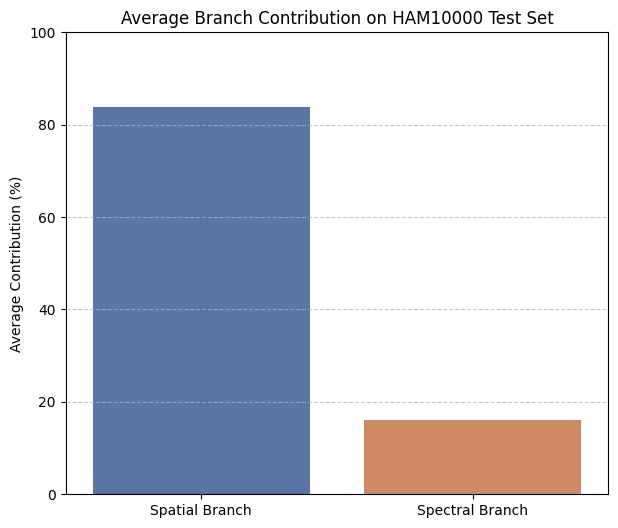


--- Generating Combined Distribution Plot (All Filled) ---


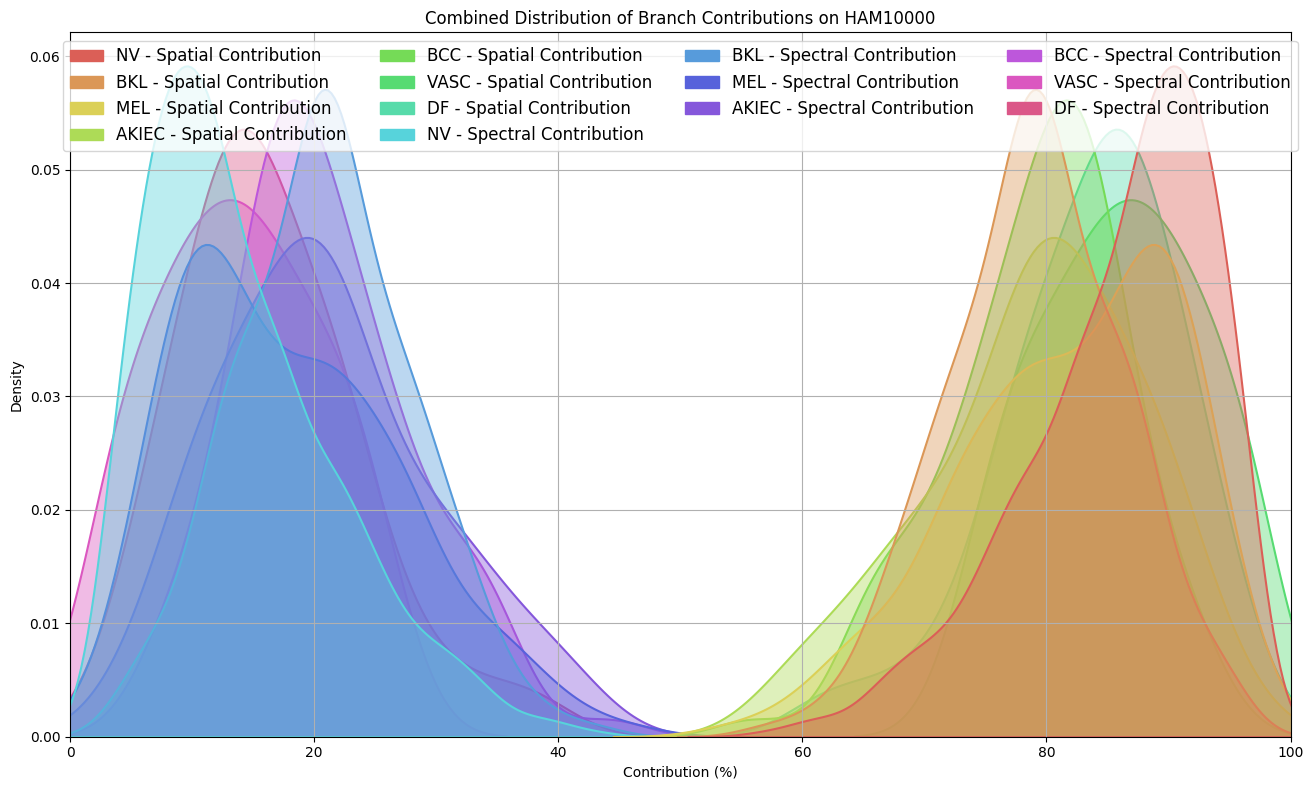


--- Generating Per-Class Distribution Plots ---


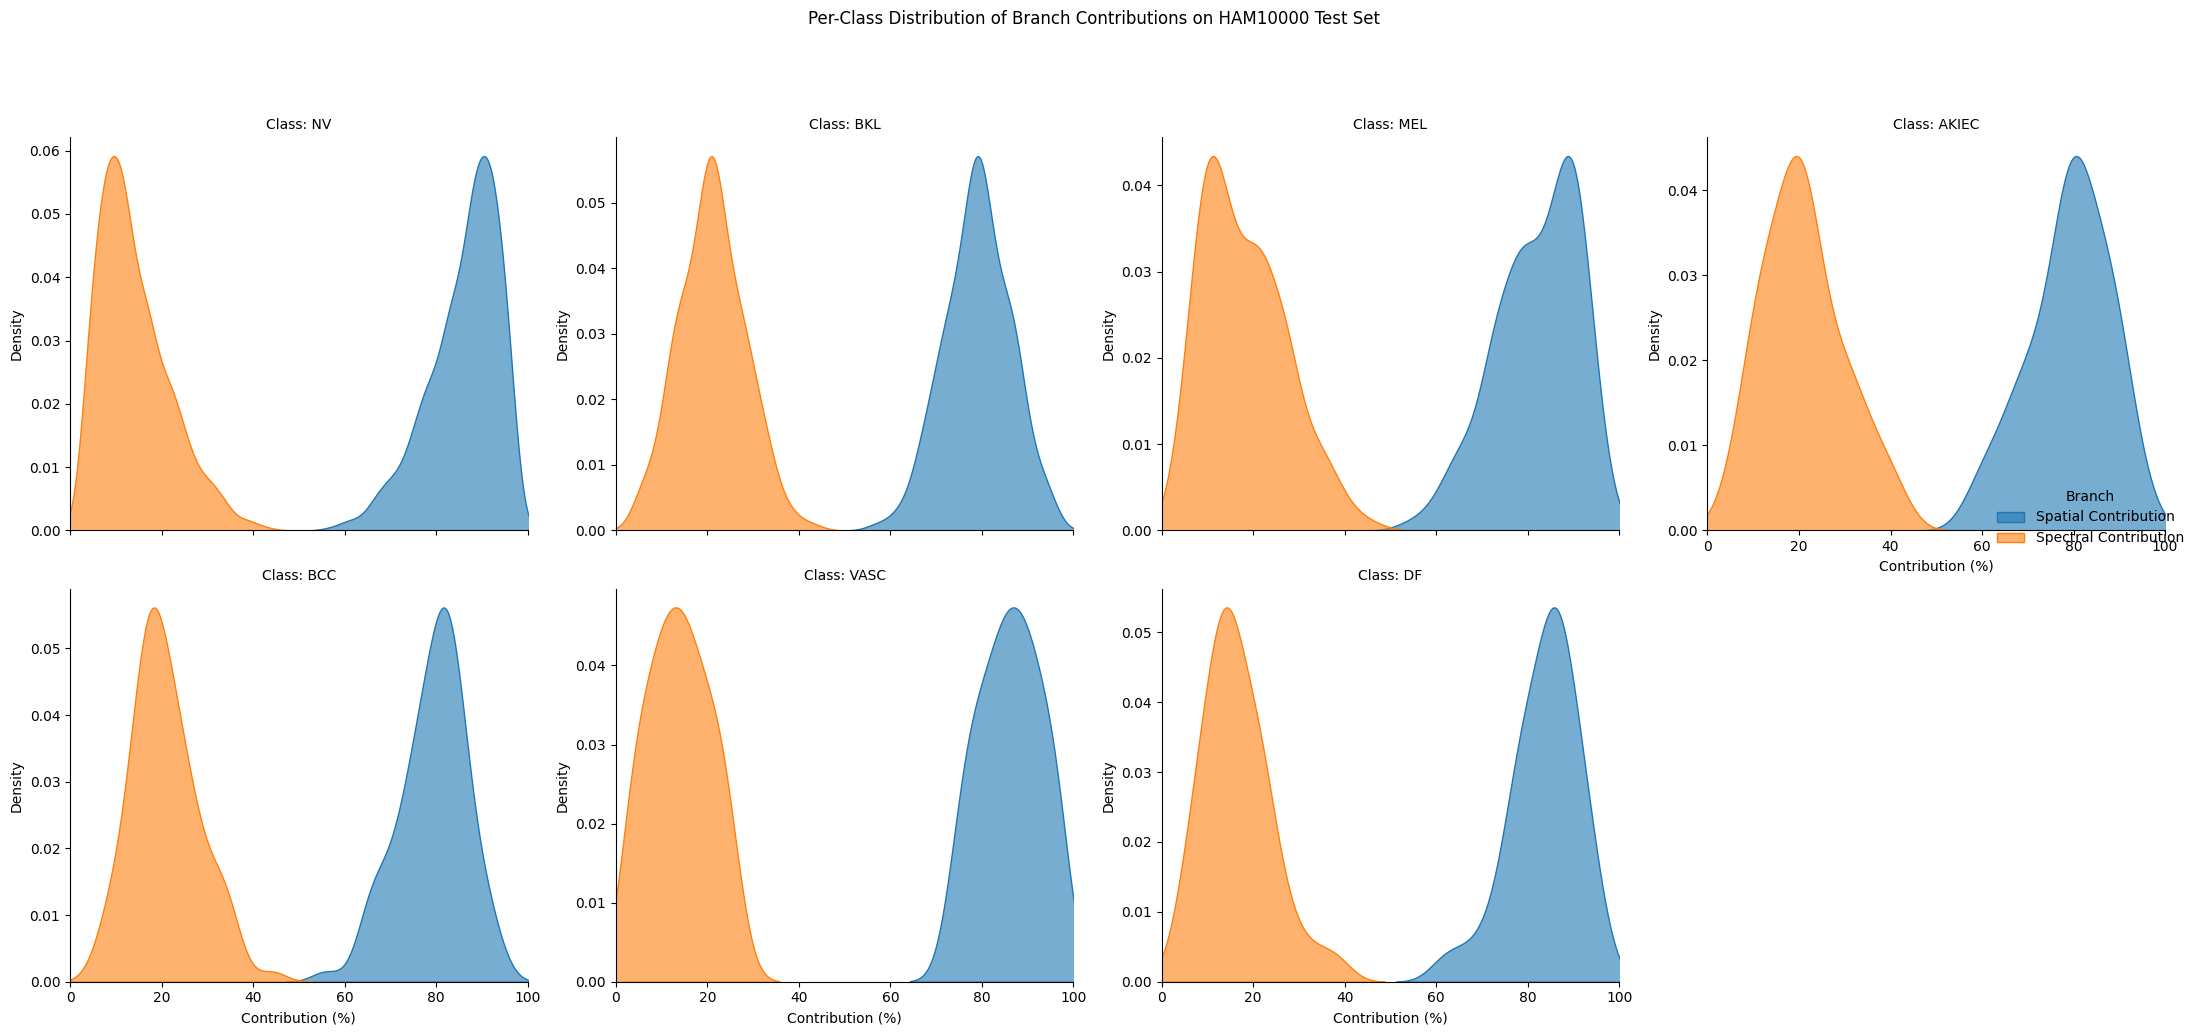

In [ ]:
# ==============================================================================
# BLOCK 5: ANALYSIS AND VISUALIZATION
# ==============================================================================

# --- Calculating L2 Norms and Contributions ---
spatial_norms = np.linalg.norm(spatial_vectors, axis=1)
spectral_norms = np.linalg.norm(spectral_vectors, axis=1)
total_norms = spatial_norms + spectral_norms; total_norms[total_norms == 0] = 1e-6
spatial_contribution = (spatial_norms / total_norms) * 100
spectral_contribution = (spectral_norms / total_norms) * 100

# --- Preparing DataFrame for all analyses ---
df_contrib = pd.DataFrame({
    'Spatial Contribution': spatial_contribution,
    'Spectral Contribution': spectral_contribution,
    'True Label': [CLASS_NAMES[i] for i in y_test.flatten()]
})

# Melted DataFrame for distribution plots
df_melted = df_contrib.melt(
    id_vars=['True Label'],
    value_vars=['Spatial Contribution', 'Spectral Contribution'],
    var_name='Branch',
    value_name='Contribution (%)'
)

# --- Reporting Overall and Per-Class Average Contributions ---
avg_spatial_contrib = df_contrib['Spatial Contribution'].mean()
avg_spectral_contrib = df_contrib['Spectral Contribution'].mean()
print("\n" + "="*60); print(f"    BRANCH CONTRIBUTION ANALYSIS ({DATASET_TO_EVALUATE})"); print("="*60)
print(f"Overall Average Spatial Branch Contribution:  {avg_spatial_contrib:.2f}%")
print(f"Overall Average Spectral Branch Contribution: {avg_spectral_contrib:.2f}%")
print("-" * 60)
print("Per-Class Average Contributions:")
class_wise_avg = df_contrib.groupby('True Label').mean()
print(class_wise_avg.to_string(float_format="%.2f%%"))
print("="*60 + "\n")

# --- Visualizing the Results ---

# 1. Bar Chart for the Overall Average
plt.figure(figsize=(7, 6))
palette = sns.color_palette("deep")
sns.barplot(x=['Spatial Branch', 'Spectral Branch'], y=[avg_spatial_contrib, avg_spectral_contrib], palette=[palette[0], palette[1]])
plt.ylabel("Average Contribution (%)")
plt.title(f"Average Branch Contribution on {DATASET_TO_EVALUATE} Test Set")
plt.ylim(0, 100); plt.grid(axis='y', linestyle='--', alpha=0.7); plt.show()

# --- COMBINED DISTRIBUTION PLOT ---
import matplotlib.patches as mpatches

print("\n--- Generating Combined Distribution Plot (All Filled) ---")
plt.figure(figsize=(14, 8))
ax = plt.gca() # Get the current axes

# Creating a unique color for each combination of "True Label" and "Branch"
num_labels = len(df_melted['True Label'].unique())
num_branches = len(df_melted['Branch'].unique())
palette = sns.color_palette("hls", n_colors=num_labels * num_branches)

# Creating a new column that combines the class and branch for the hue mapping
df_melted['Hue Category'] = df_melted['True Label'].str.cat(df_melted['Branch'], sep=' - ')

# Plotting the KDE using the new combined category for the color
sns.kdeplot(
    data=df_melted,
    x="Contribution (%)",
    hue="Hue Category",
    fill=True,
    alpha=0.4,
    linewidth=1.5,
    common_norm=False,
    palette=palette,
    ax=ax,
    legend=False
)

# Getting the unique categories and their corresponding colors
hue_categories = df_melted['Hue Category'].unique()
colors = palette[:len(hue_categories)]

# Creating a list of "patches" for the legend
legend_patches = [mpatches.Patch(color=color, label=label)
                  for label, color in zip(hue_categories, colors)]

# Creating the legend manually and placing it INSIDE the grid at the top center
plt.legend(
    handles=legend_patches,
    #title='Class - Branch',
    loc='upper center',
    ncol=min(4, len(CLASS_NAMES)),
    fontsize='large'
)

plt.title(f"Combined Distribution of Branch Contributions on {DATASET_TO_EVALUATE}")
plt.grid(True)
plt.xlim(0, 100)
plt.tight_layout()
plt.show()

# --- CLASS-WISE SEPARATE PLOTS ---
# A "melted" DataFrame for the FacetGrid plot
print("\n--- Generating Per-Class Distribution Plots ---")
df_melted = df_contrib.melt(
    id_vars=['True Label'],
    value_vars=['Spatial Contribution', 'Spectral Contribution'],
    var_name='Branch',
    value_name='Contribution (%)'
)
# 4. Creating the separate, per-class distribution plots
g = sns.FacetGrid(
    df_melted, col="True Label", hue="Branch", col_wrap=min(4, len(CLASS_NAMES)),
    height=5, sharex=True, sharey=False
)
g.map(sns.kdeplot, "Contribution (%)", fill=True, alpha=0.6, common_norm=False)
g.add_legend()
g.fig.suptitle(f'Per-Class Distribution of Branch Contributions on {DATASET_TO_EVALUATE} Test Set', y=1.03)
g.set(xlim=(0, 100))
g.set_titles("Class: {col_name}")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

## **Using the proposed *Balanced Contribution Score***


    BALANCED BRANCH CONTRIBUTION ANALYSIS (HAM10000)
Average Spatial Branch Contribution:  35.84%
Average Spectral Branch Contribution: 64.16%
------------------------------------------------------------
Per-Class Average Contributions:
            Spatial Contribution (%)  Spectral Contribution (%)
True Label                                                     
AKIEC                         28.00%                     72.00%
BCC                           27.22%                     72.78%
BKL                           27.08%                     72.92%
DF                            34.10%                     65.90%
MEL                           32.84%                     67.16%
NV                            39.69%                     60.31%
VASC                          39.59%                     60.41%



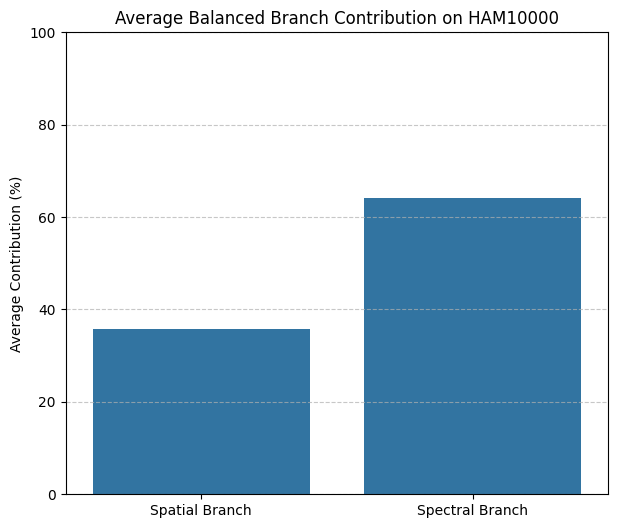


--- Generating Combined Distribution Plot (All Filled) ---


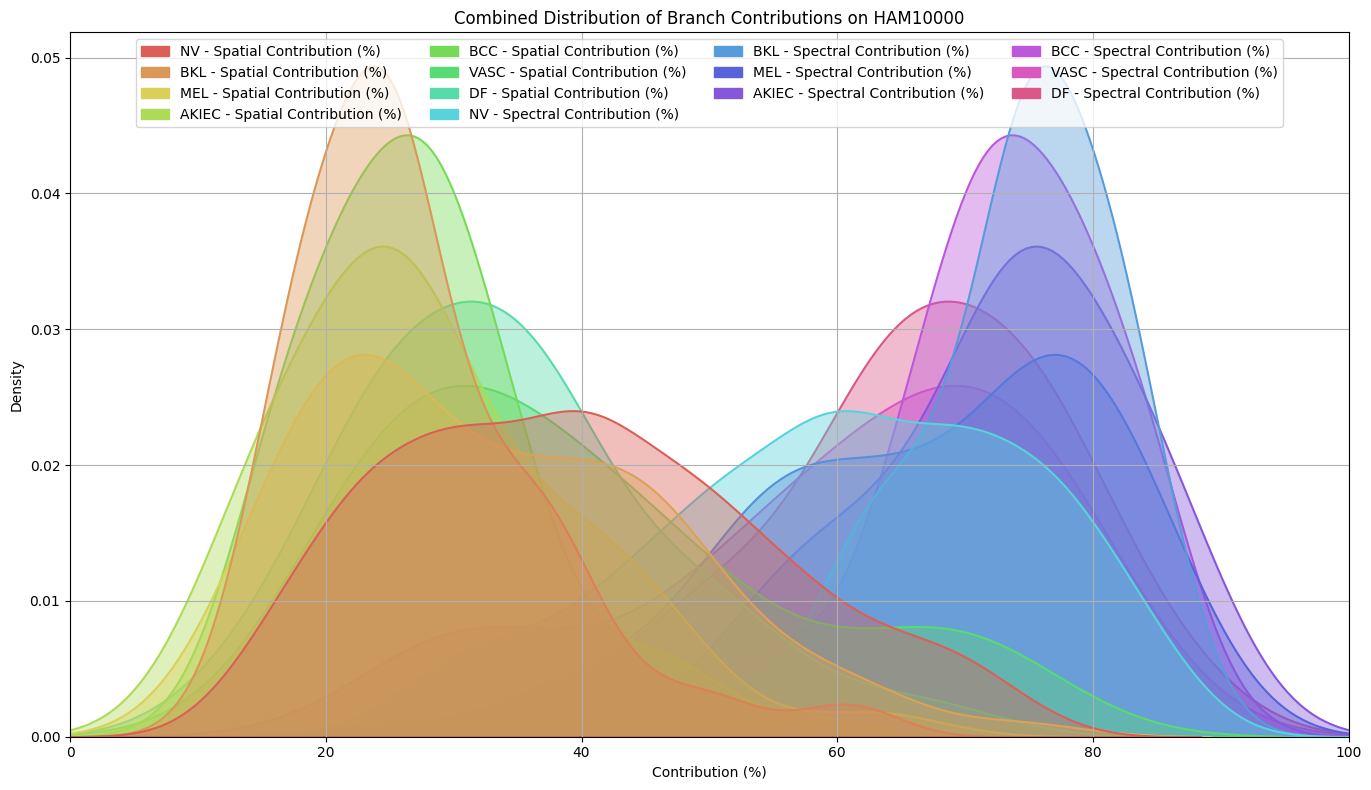

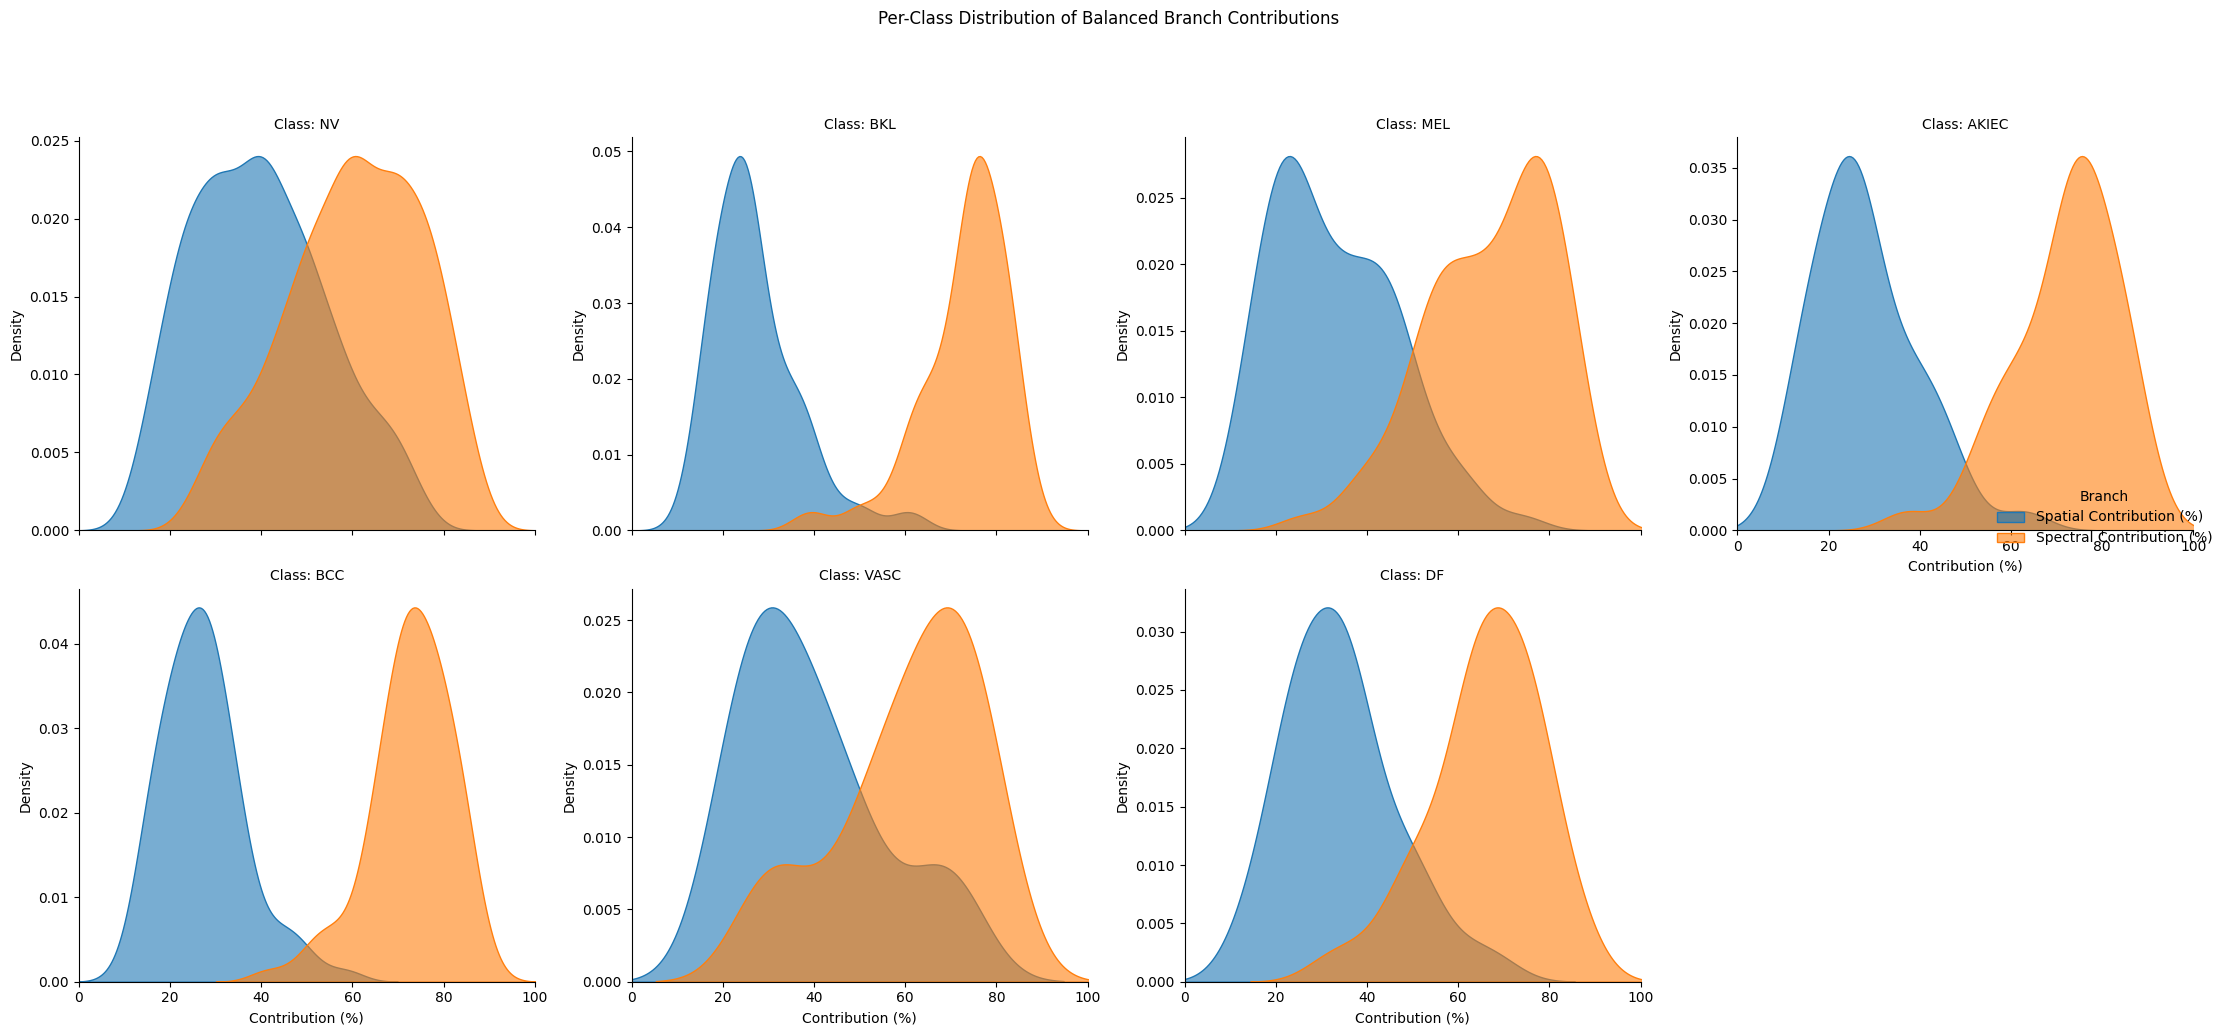

In [ ]:
# --- 1. Calculating Component Metrics ---
# Total Magnitude (L2 Norm)
spatial_total_mag = np.linalg.norm(spatial_vectors, axis=1)
spectral_total_mag = np.linalg.norm(spectral_vectors, axis=1)

# Per-Feature Magnitude
spatial_dim = spatial_vectors.shape[1]
spectral_dim = spectral_vectors.shape[1]
spatial_per_feature_mag = spatial_total_mag / spatial_dim
spectral_per_feature_mag = spectral_total_mag / spectral_dim

# --- Calculating the Balanced Contribution Score ---
# Geometric Mean of the two magnitudes
spatial_score = np.sqrt(spatial_total_mag * spatial_per_feature_mag)
spectral_score = np.sqrt(spectral_total_mag * spectral_per_feature_mag)

# --- Calculating Percentage Contributions based on the new score ---
total_score = spatial_score + spectral_score
total_score[total_score == 0] = 1e-6 # Avoid division by zero

spatial_contribution_pct = (spatial_score / total_score) * 100
spectral_contribution_pct = (spectral_score / total_score) * 100

# --- Reporting the Averages ---
avg_spatial_contrib = np.mean(spatial_contribution_pct)
avg_spectral_contrib = np.mean(spectral_contribution_pct)

print("\n" + "="*60)
print(f"    BALANCED BRANCH CONTRIBUTION ANALYSIS ({DATASET_TO_EVALUATE})")
print("="*60)
print(f"Average Spatial Branch Contribution:  {avg_spatial_contrib:.2f}%")
print(f"Average Spectral Branch Contribution: {avg_spectral_contrib:.2f}%")
print("-" * 60)

# --- Per-Class Reporting ---
df_contrib = pd.DataFrame({
    'Spatial Contribution (%)': spatial_contribution_pct,
    'Spectral Contribution (%)': spectral_contribution_pct,
    'True Label': [CLASS_NAMES[i] for i in y_test.flatten()]
})
print("Per-Class Average Contributions:")
class_wise_avg = df_contrib.groupby('True Label').mean()
print(class_wise_avg.to_string(float_format="%.2f%%"))
print("="*60 + "\n")

# Melted DataFrame for distribution plots
df_melted = df_contrib.melt(
    id_vars=['True Label'],
    value_vars=['Spatial Contribution (%)', 'Spectral Contribution (%)'],
    var_name='Branch',
    value_name='Contribution (%)'
)

# --- Visualizing the Results ---

# Bar Chart for the Average
plt.figure(figsize=(7, 6))
sns.barplot(x=['Spatial Branch', 'Spectral Branch'], y=[avg_spatial_contrib, avg_spectral_contrib])
plt.ylabel("Average Contribution (%)")
plt.title(f"Average Balanced Branch Contribution on {DATASET_TO_EVALUATE}")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# --- COMBINED DISTRIBUTION PLOT ---
import matplotlib.patches as mpatches

print("\n--- Generating Combined Distribution Plot (All Filled) ---")
plt.figure(figsize=(14, 8))
ax = plt.gca()

# Creating a unique color for each combination of "True Label" and "Branch"
num_labels = len(df_melted['True Label'].unique())
num_branches = len(df_melted['Branch'].unique())
palette = sns.color_palette("hls", n_colors=num_labels * num_branches)

# Creating a new column that combines the class and branch for the hue mapping
df_melted['Hue Category'] = df_melted['True Label'].str.cat(df_melted['Branch'], sep=' - ')

# Plotting the KDE using the new combined category for the color
sns.kdeplot(
    data=df_melted,
    x="Contribution (%)",
    hue="Hue Category",
    fill=True,
    alpha=0.4,
    linewidth=1.5,
    common_norm=False,
    palette=palette,
    ax=ax,
    legend=False
)

# Getting the unique categories and their corresponding colors
hue_categories = df_melted['Hue Category'].unique()
colors = palette[:len(hue_categories)] # Use the same colors sns used

# Creating a list of "patches" for the legend
legend_patches = [mpatches.Patch(color=color, label=label)
                  for label, color in zip(hue_categories, colors)]

# Creating the legend manually and placing it INSIDE the grid at the top center
plt.legend(
    handles=legend_patches,
    #title='Class - Branch',
    loc='upper center',
    ncol=min(4, len(CLASS_NAMES)),
    fontsize='medium'
)

plt.title(f"Combined Distribution of Branch Contributions on {DATASET_TO_EVALUATE}")
plt.grid(True)
plt.xlim(0, 100)
plt.tight_layout()
plt.show()

# Per-Class Distribution Plot
df_melted = df_contrib.melt(
    id_vars=['True Label'],
    value_vars=['Spatial Contribution (%)', 'Spectral Contribution (%)'],
    var_name='Branch',
    value_name='Contribution (%)'
)
g = sns.FacetGrid(df_melted, col="True Label", hue="Branch", col_wrap=min(4, len(CLASS_NAMES)), height=5, sharex=True, sharey=False)
g.map(sns.kdeplot, "Contribution (%)", fill=True, alpha=0.6, common_norm=False)
g.add_legend()
g.fig.suptitle(f'Per-Class Distribution of Balanced Branch Contributions', y=1.03)
g.set(xlim=(0, 100))
g.set_titles("Class: {col_name}")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# **BUSI**

In [ ]:
# --- Configuration ---

# 1. Choosing the dataset the model was trained on ("HAM10000", "BRISC2025", "BUSI", or "ChestXRay")
DATASET_TO_EVALUATE = "BUSI"

# 2. Providing the full path to the saved .keras model.
MODEL_TO_EVALUATE_PATH = "/content/drive/MyDrive/S3F_Net_Models/concatenation_s3f_net.keras"

--- Mounting Google Drive ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ==============================================================================
# BLOCK 2: DATA PREPARATION
# ==============================================================================
# This block unzips and loads the appropriate test set (images and labels)
# for the selected model.

# --- Unzip Logic ---
TEMP_DATA_DIR = f"/content/{DATASET_TO_EVALUATE}_temp"

# --- Assign correct ZIP Path and a DEFINED Base Path ---
if DATASET_TO_EVALUATE == "HAM10000":
    ZIP_PATH = ZIP_PATH_HAM10000
    # Defines the base path to the unzipped HAM10000 data
    DATASET_BASE_PATH = os.path.join(TEMP_DATA_DIR, "HAM10000 Dataset")
elif DATASET_TO_EVALUATE == "BRISC2025":
    ZIP_PATH = ZIP_PATH_BRISC2025
    # Defines the base path to the unzipped BRISC data
    DATASET_BASE_PATH = os.path.join(TEMP_DATA_DIR, "brisc2025/classification_task")
elif DATASET_TO_EVALUATE == "BUSI":
    ZIP_PATH = ZIP_PATH_BUSI
    # Defines the base path to the unzipped BUSI data
    DATASET_BASE_PATH = os.path.join(TEMP_DATA_DIR, "Dataset_BUSI_with_GT")
elif DATASET_TO_EVALUATE == "ChestXRay":
    ZIP_PATH = ZIP_PATH_XRAY
    # Defines the base path to the unzipped Chest X-Ray data
    DATASET_BASE_PATH = os.path.join(TEMP_DATA_DIR, "chest_xray")
else:
    raise ValueError("Invalid DATASET_TO_EVALUATE. Choose from 'HAM10000', 'BRISC2025', 'BUSI', or 'ChestXRay'.")

# --- Unzip Logic ---
if not os.path.exists(TEMP_DATA_DIR):
    print(f"\n--- Unzipping {DATASET_TO_EVALUATE} dataset... ---")
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(TEMP_DATA_DIR)
    print("--- Unzipping complete! ---")
else:
    print(f"\n--- {DATASET_TO_EVALUATE} dataset already unzipped. ---")


# --- Data loading functions that return (images, labels, class_names) ---

def load_ham10000_test_set_with_labels(base_path):
    IMG_SIZE = (225, 300) # Corrected from your previous code
    csv_path = os.path.join(base_path, 'Test_GroundTruth.csv')
    image_dir = os.path.join(base_path, 'Test_images')
    df = pd.read_csv(csv_path)
    class_names = list(df.columns[1:])
    labels_one_hot = df.iloc[:, 1:].values
    labels_int = np.argmax(labels_one_hot, axis=1)
    images, image_ids = [], df['image'].values
    print(f"Loading {len(image_ids)} HAM10000 test images...")
    for img_id in image_ids:
        img_path = os.path.join(image_dir, f"{img_id}.jpg")
        img = cv2.imread(img_path); img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE[1], IMG_SIZE[0]))
        img = img.astype('float32') / 255.0; images.append(img)
    return np.array(images), np.array(labels_int), class_names

def load_brisc_test_set_with_labels(folder_path):
    IMG_SIZE = (256, 256)
    images, labels = [], []
    class_names = sorted(os.listdir(folder_path))
    class_map = {name: i for i, name in enumerate(class_names)}
    print(f"Loading BRISC2025 test images from: {folder_path}")
    for class_name in class_names:
        class_path = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_path): continue
        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, IMG_SIZE)
            img = img.astype('float32') / 255.0
            images.append(img[..., np.newaxis])
            labels.append(class_map[class_name])
    return np.array(images), np.array(labels), class_names

def load_xray_test_set_with_labels(folder_path):
    IMG_SIZE = (384, 512) # Corrected from your previous code
    images, labels = [], []
    class_names = ['NORMAL', 'PNEUMONIA']
    class_map = {name: i for i, name in enumerate(class_names)}
    print(f"Loading Chest X-Ray test images from: {folder_path}")
    for class_name in class_names:
        class_path = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_path): continue
        for filename in os.listdir(class_path):
            if not filename.lower().endswith(('.jpeg', '.jpg', '.png')): continue
            img_path = os.path.join(class_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (IMG_SIZE[1], IMG_SIZE[0]))
            img = img.astype('float32') / 255.0
            images.append(img[..., np.newaxis])
            labels.append(class_map[class_name])
    return np.array(images), np.array(labels), class_names

def load_busi_full_dataset(dataset_path):
    IMG_SIZE = (256, 256)
    categories = ['benign', 'malignant', 'normal']
    images, labels = [], []
    print(f"Loading full BUSI dataset from: {dataset_path}")
    for class_idx, category in enumerate(categories):
        category_path = os.path.join(dataset_path, category)
        if not os.path.exists(category_path) or not os.path.isdir(category_path): continue
        for filename in os.listdir(category_path):
            if '_mask' in filename or not filename.lower().endswith('.png'): continue
            img_path = os.path.join(category_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, IMG_SIZE)
            img = img.astype('float32') / 255.0
            images.append(img[..., np.newaxis])
            labels.append(class_idx)
    return np.array(images), np.array(labels), categories

# --- Loading the correct test set with labels ---
print("\n--- Loading Test Data with Labels ---")
if DATASET_TO_EVALUATE == "HAM10000":
    X_test, y_test, CLASS_NAMES = load_ham10000_test_set_with_labels(DATASET_BASE_PATH)
elif DATASET_TO_EVALUATE == "BRISC2025":
    X_test, y_test, CLASS_NAMES = load_brisc_test_set_with_labels(os.path.join(DATASET_BASE_PATH, "test"))
elif DATASET_TO_EVALUATE == "BUSI":
    images, labels, CLASS_NAMES = load_busi_full_dataset(DATASET_BASE_PATH)
    _, X_test, _, y_test = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state=RANDOM_STATE)
elif DATASET_TO_EVALUATE == "ChestXRay":
    X_test, y_test, CLASS_NAMES = load_xray_test_set_with_labels(os.path.join(DATASET_BASE_PATH, "test"))

# --- Final Checks ---
print(f"\nLoaded {len(X_test)} test samples and {len(y_test)} test labels.")
print(f"Dataset: {DATASET_TO_EVALUATE}")
print(f"Class Names: {CLASS_NAMES}")
num_classes = len(CLASS_NAMES)


--- Unzipping BUSI dataset... ---
--- Unzipping complete! ---

--- Loading Test Data with Labels ---
Loading full BUSI dataset from: /content/BUSI_temp/Dataset_BUSI_with_GT

Loaded 156 test samples and 156 test labels.
Dataset: BUSI
Class Names: ['benign', 'malignant', 'normal']


In [ ]:
# ==============================================================================
# BLOCK 3: MODEL RE-CREATION FOR EXPLAINABILITY
# ==============================================================================
# This block re-creates the S³F-Net architecture and modifies it to output
# the intermediate feature vectors we need to analyze.

# --- Custom SpectralFilter Layer & Encoders ---
class SpectralFilterLayer(layers.Layer):
    def __init__(self, filters, **kwargs): super().__init__(**kwargs); self.filters = filters
    def build(self, input_shape):
        _, h, w, c = input_shape
        fft_shape = (h, w // 2 + 1)
        self.real_weights = self.add_weight(name='real_weights', shape=(c, self.filters, *fft_shape), initializer='glorot_uniform')
        self.imag_weights = self.add_weight(name='imag_weights', shape=(c, self.filters, *fft_shape), initializer='glorot_uniform')
        self.bias = self.add_weight(name='bias', shape=(self.filters,), initializer='zeros')
    def call(self, inputs):
        inputs_p = tf.transpose(inputs, [0, 3, 1, 2])
        inputs_fft = tf.signal.rfft2d(inputs_p)
        kernel_fft = tf.complex(self.real_weights, self.imag_weights)
        output_fft = tf.einsum('bchw,cfhw->bfhw', inputs_fft, kernel_fft)
        output_s = tf.signal.irfft2d(output_fft)
        output_p = tf.transpose(output_s, [0, 2, 3, 1])
        return output_p + self.bias
    def get_config(self):
        config = super().get_config()
        config.update({"filters": self.filters})
        return config

def build_spatial_encoder(inputs):
    x = inputs
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(32, 3, padding='same')(x); x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, 3, padding='same')(x); x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(128, 3, padding='same')(x); x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, 3, padding='same')(x); x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.4)(x)
    return x

def depthwise_sep_block(x, filters, kernel_size=3, strides=1):
    x = layers.DepthwiseConv2D(kernel_size, strides=strides, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, 1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    return x

def build_spectral_summary_branch(inputs):
    x = SpectralFilterLayer(32)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Uncomment for SpectraNet-2 variations
    x = SpectralFilterLayer(64)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Uncomment for SpectraNet-1 variations
    # x = depthwise_sep_block(x, 64)
    # x = layers.MaxPooling2D(2)(x)

    x = depthwise_sep_block(x, 128)
    x = layers.MaxPooling2D(2)(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(16, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1875)(x)
    x = layers.Dense(4, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3125)(x)

    return x

# --- Explainable Model Builder ---
def build_s3f_net_explainable(input_shape, num_classes):
    """Builds the S³F-Net but also outputs the intermediate branch vectors."""
    inputs = layers.Input(input_shape)

    # Tower 1: Deep Spatial Branch
    spatial_features = build_spatial_encoder(inputs)
    spatial_vector_raw = layers.GlobalAveragePooling2D()(spatial_features)
    spatial_refined = layers.Dense(512, activation='relu', name='fc_spatial')(spatial_vector_raw)
    spatial_refined = layers.BatchNormalization()(spatial_refined)
    spatial_refined = layers.Dropout(0.5)(spatial_refined)

    # Tower 2: Spectral Summary Branch
    spectral_summary_vector = build_spectral_summary_branch(inputs)

    # Fusion
    fused_vector = layers.concatenate([spatial_refined, spectral_summary_vector])
    outputs = layers.Dense(num_classes, activation='softmax')(fused_vector)

    # Model with Multiple Outputs
    model = models.Model(
        inputs=inputs,
        outputs=[outputs, spatial_refined, spectral_summary_vector],
        name="Explainable_S3F_Net"
    )
    return model

# Instantiating the explainable model
if DATASET_TO_EVALUATE == "HAM10000":
    num_classes = 7
elif DATASET_TO_EVALUATE == "BRISC2025":
    num_classes = 4
elif DATASET_TO_EVALUATE == "BUSI":
    num_classes = 3
elif DATASET_TO_EVALUATE == "ChestXRay":
    num_classes = 1          # If Sigmoid --> 1, Else if Softmax --> 2

explainable_model = build_s3f_net_explainable(X_test.shape[1:], num_classes=num_classes)

# --- Loading the weights from our trained model ---
print(f"\n--- Loading weights from: {MODEL_TO_EVALUATE_PATH} ---")
explainable_model.load_weights(MODEL_TO_EVALUATE_PATH)
print("Weights loaded successfully.")


--- Loading weights from: /content/drive/MyDrive/S2F_Net_Models/concatenation_s2f_net.keras ---
Weights loaded successfully.


In [ ]:
# ==============================================================================
# BLOCK 4: Loading Results
# ==============================================================================
print("\n--- Generating predictions and extracting branch vectors ---")
results = explainable_model.predict(X_test)
y_pred_proba, spatial_vectors, spectral_vectors = results[0], results[1], results[2]



--- Generating predictions and extracting branch vectors ---
5/5 ━━━━━━━━━━━━━━━━━━━━ 98s 19s/step


## **Using L2 Norm**


    BRANCH CONTRIBUTION ANALYSIS (BUSI)
Overall Average Spatial Branch Contribution:  85.77%
Overall Average Spectral Branch Contribution: 14.23%
------------------------------------------------------------
Per-Class Average Contributions:
            Spatial Contribution  Spectral Contribution
True Label                                             
benign                    86.05%                 13.95%
malignant                 85.86%                 14.14%
normal                    84.71%                 15.29%



/tmp/ipython-input-2929078036.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Spatial Branch', 'Spectral Branch'], y=[avg_spatial_contrib, avg_spectral_contrib], palette=[palette[0], palette[1]])


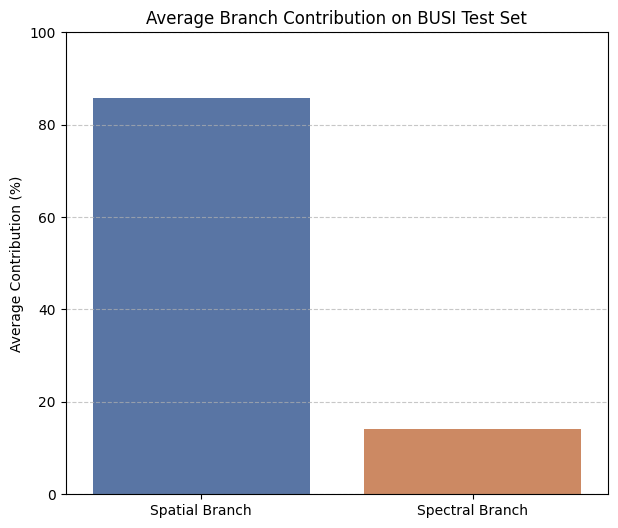


--- Generating Combined Distribution Plot (All Filled) ---


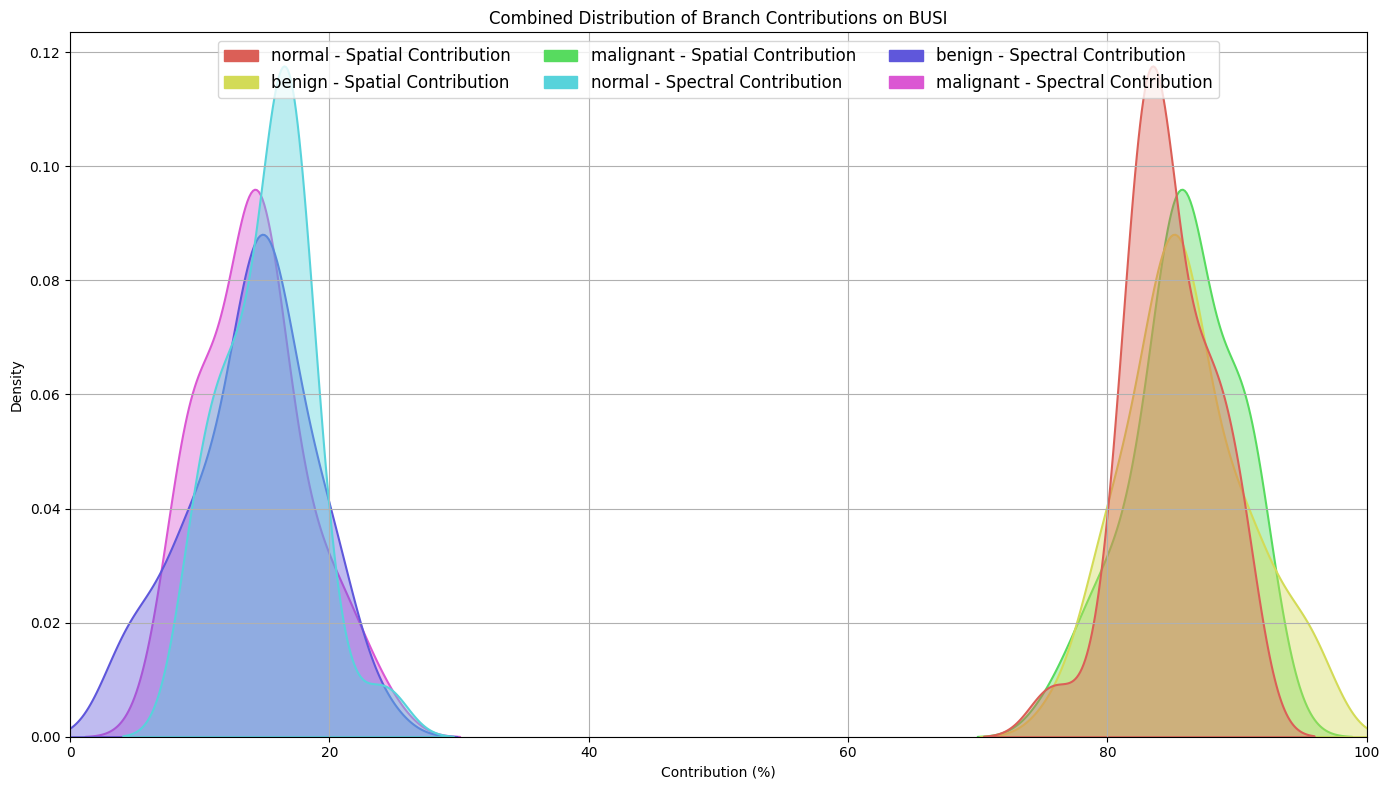


--- Generating Per-Class Distribution Plots ---


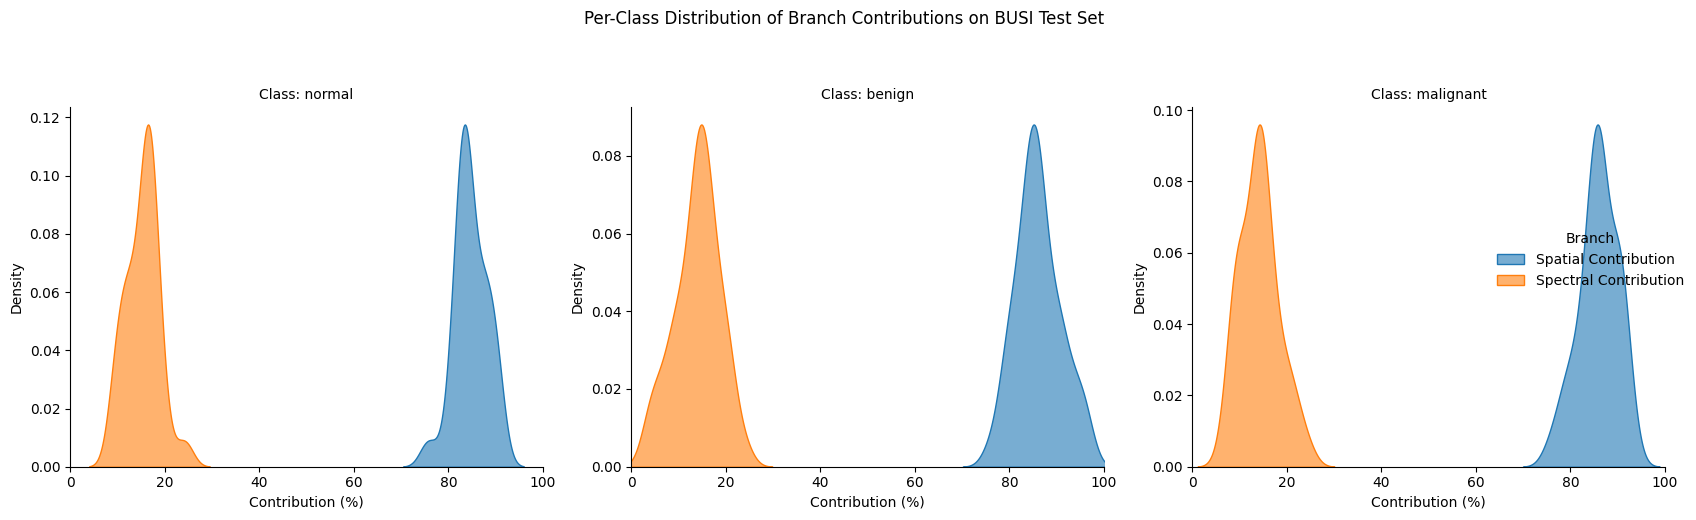

In [ ]:
# ==============================================================================
# BLOCK 5: ANALYSIS AND VISUALIZATION
# ==============================================================================

# --- Calculating L2 Norms and Contributions ---
spatial_norms = np.linalg.norm(spatial_vectors, axis=1)
spectral_norms = np.linalg.norm(spectral_vectors, axis=1)
total_norms = spatial_norms + spectral_norms; total_norms[total_norms == 0] = 1e-6
spatial_contribution = (spatial_norms / total_norms) * 100
spectral_contribution = (spectral_norms / total_norms) * 100

# --- Preparing DataFrame for all analyses ---
df_contrib = pd.DataFrame({
    'Spatial Contribution': spatial_contribution,
    'Spectral Contribution': spectral_contribution,
    'True Label': [CLASS_NAMES[i] for i in y_test.flatten()]
})

# Melted DataFrame for distribution plots
df_melted = df_contrib.melt(
    id_vars=['True Label'],
    value_vars=['Spatial Contribution', 'Spectral Contribution'],
    var_name='Branch',
    value_name='Contribution (%)'
)

# --- Reporting Overall and Per-Class Average Contributions ---
avg_spatial_contrib = df_contrib['Spatial Contribution'].mean()
avg_spectral_contrib = df_contrib['Spectral Contribution'].mean()
print("\n" + "="*60); print(f"    BRANCH CONTRIBUTION ANALYSIS ({DATASET_TO_EVALUATE})"); print("="*60)
print(f"Overall Average Spatial Branch Contribution:  {avg_spatial_contrib:.2f}%")
print(f"Overall Average Spectral Branch Contribution: {avg_spectral_contrib:.2f}%")
print("-" * 60)
print("Per-Class Average Contributions:")
class_wise_avg = df_contrib.groupby('True Label').mean()
print(class_wise_avg.to_string(float_format="%.2f%%"))
print("="*60 + "\n")

# --- Visualizing the Results ---

# 1. Bar Chart for the Overall Average
plt.figure(figsize=(7, 6))
palette = sns.color_palette("deep")
sns.barplot(x=['Spatial Branch', 'Spectral Branch'], y=[avg_spatial_contrib, avg_spectral_contrib], palette=[palette[0], palette[1]])
plt.ylabel("Average Contribution (%)")
plt.title(f"Average Branch Contribution on {DATASET_TO_EVALUATE} Test Set")
plt.ylim(0, 100); plt.grid(axis='y', linestyle='--', alpha=0.7); plt.show()

# --- COMBINED DISTRIBUTION PLOT ---
import matplotlib.patches as mpatches

print("\n--- Generating Combined Distribution Plot (All Filled) ---")
plt.figure(figsize=(14, 8))
ax = plt.gca() # Get the current axes

# Creating a unique color for each combination of "True Label" and "Branch"
num_labels = len(df_melted['True Label'].unique())
num_branches = len(df_melted['Branch'].unique())
palette = sns.color_palette("hls", n_colors=num_labels * num_branches)

# Creating a new column that combines the class and branch for the hue mapping
df_melted['Hue Category'] = df_melted['True Label'].str.cat(df_melted['Branch'], sep=' - ')

# Plotting the KDE using the new combined category for the color
sns.kdeplot(
    data=df_melted,
    x="Contribution (%)",
    hue="Hue Category",
    fill=True,
    alpha=0.4,
    linewidth=1.5,
    common_norm=False,
    palette=palette,
    ax=ax,
    legend=False
)

# Getting the unique categories and their corresponding colors
hue_categories = df_melted['Hue Category'].unique()
colors = palette[:len(hue_categories)]

# Creating a list of "patches" for the legend
legend_patches = [mpatches.Patch(color=color, label=label)
                  for label, color in zip(hue_categories, colors)]

# Creating the legend manually and placing it INSIDE the grid at the top center
plt.legend(
    handles=legend_patches,
    #title='Class - Branch',
    loc='upper center',
    ncol=min(4, len(CLASS_NAMES)),
    fontsize='large'
)

plt.title(f"Combined Distribution of Branch Contributions on {DATASET_TO_EVALUATE}")
plt.grid(True)
plt.xlim(0, 100)
plt.tight_layout()
plt.show()

# --- CLASS-WISE SEPARATE PLOTS ---
# A "melted" DataFrame for the FacetGrid plot
print("\n--- Generating Per-Class Distribution Plots ---")
df_melted = df_contrib.melt(
    id_vars=['True Label'],
    value_vars=['Spatial Contribution', 'Spectral Contribution'],
    var_name='Branch',
    value_name='Contribution (%)'
)
# 4. Creating the separate, per-class distribution plots
g = sns.FacetGrid(
    df_melted, col="True Label", hue="Branch", col_wrap=min(4, len(CLASS_NAMES)),
    height=5, sharex=True, sharey=False
)
g.map(sns.kdeplot, "Contribution (%)", fill=True, alpha=0.6, common_norm=False)
g.add_legend()
g.fig.suptitle(f'Per-Class Distribution of Branch Contributions on {DATASET_TO_EVALUATE} Test Set', y=1.03)
g.set(xlim=(0, 100))
g.set_titles("Class: {col_name}")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

## **Using the proposed *Balanced Contribution Score***


    BALANCED BRANCH CONTRIBUTION ANALYSIS (BUSI)
Average Spatial Branch Contribution:  36.42%
Average Spectral Branch Contribution: 63.58%
------------------------------------------------------------
Per-Class Average Contributions:
            Spatial Contribution (%)  Spectral Contribution (%)
True Label                                                     
benign                        37.39%                     62.61%
malignant                     36.18%                     63.82%
normal                        33.67%                     66.33%



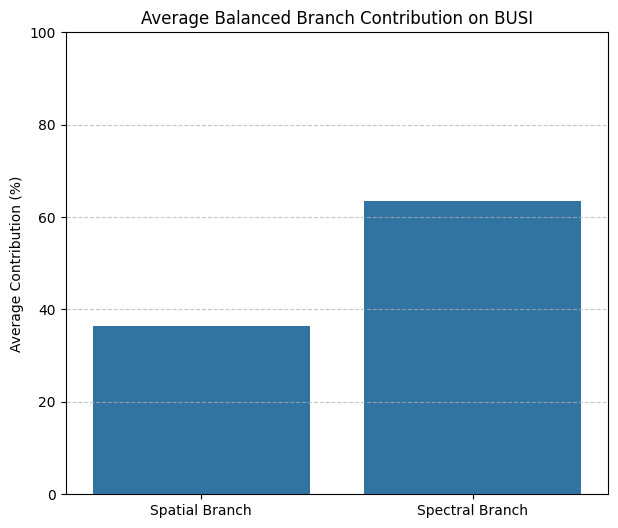


--- Generating Combined Distribution Plot (All Filled) ---


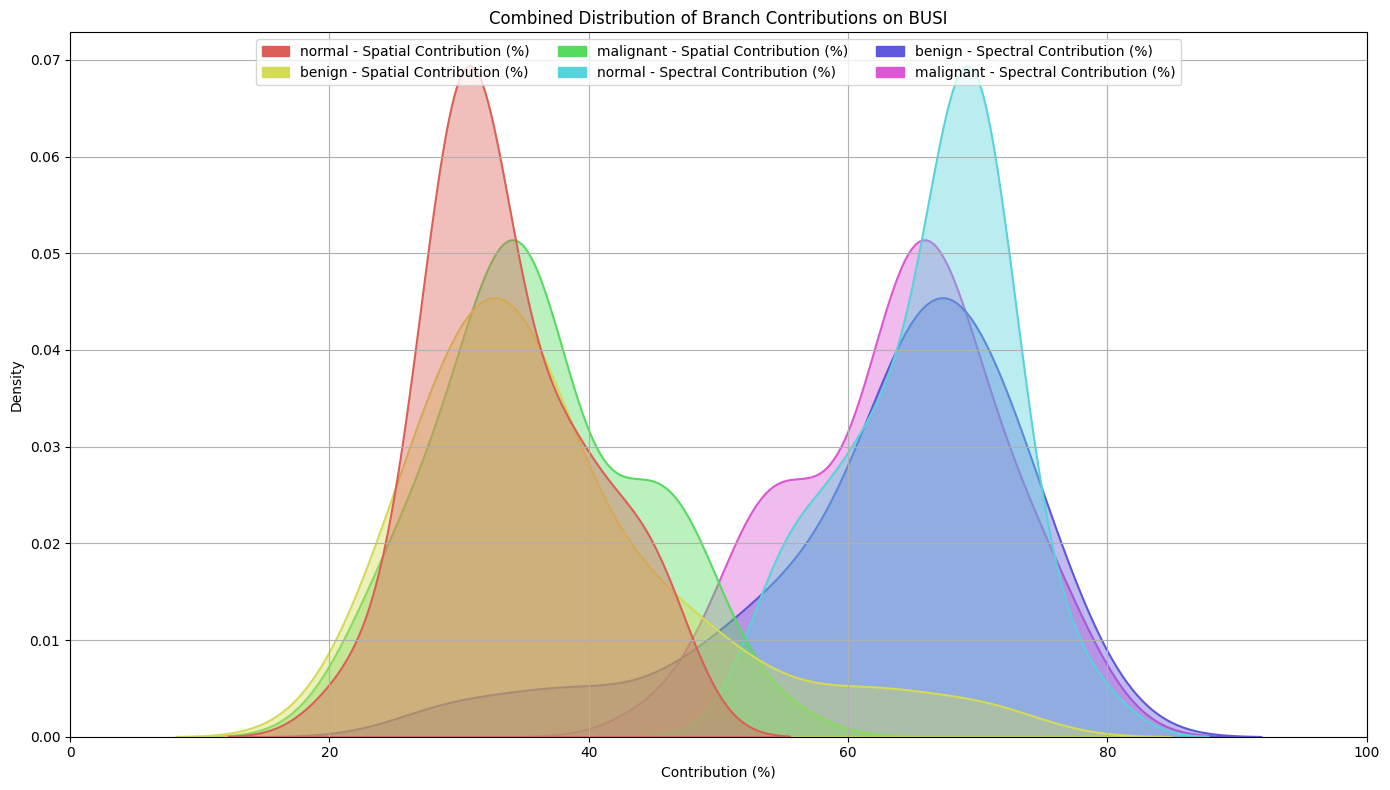

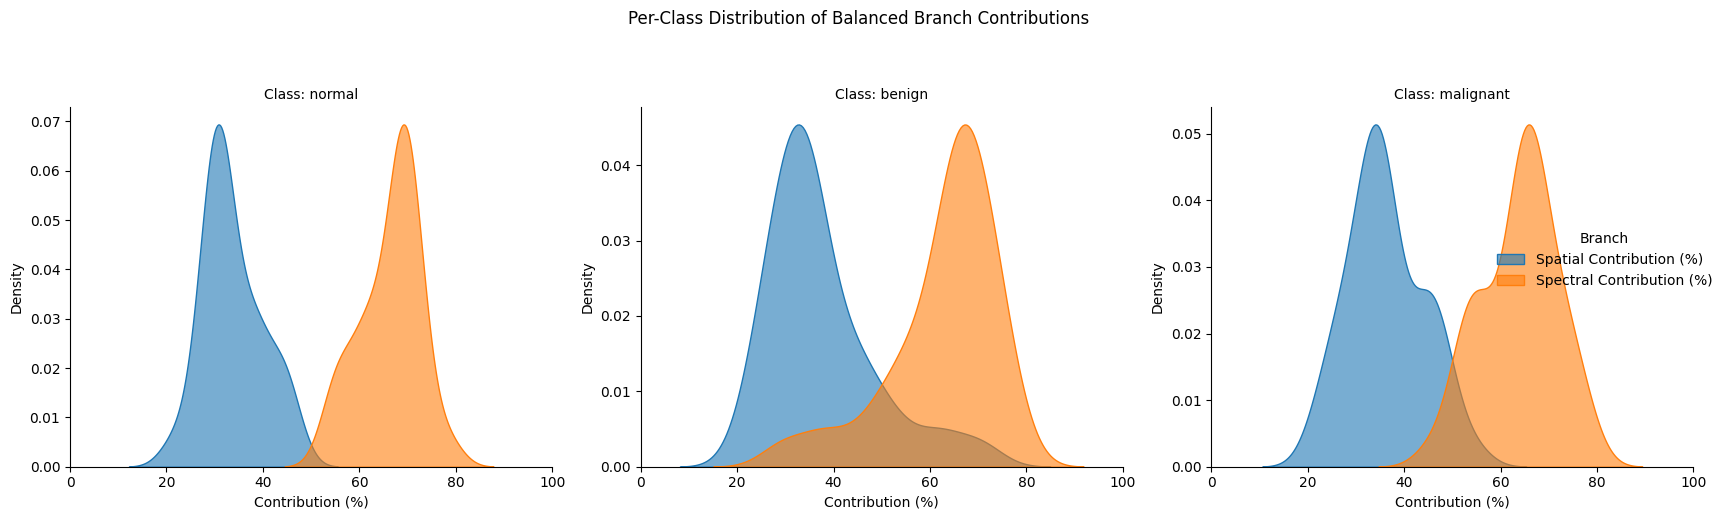

In [ ]:
# --- 1. Calculating Component Metrics ---
# Total Magnitude (L2 Norm)
spatial_total_mag = np.linalg.norm(spatial_vectors, axis=1)
spectral_total_mag = np.linalg.norm(spectral_vectors, axis=1)

# Per-Feature Magnitude
spatial_dim = spatial_vectors.shape[1]
spectral_dim = spectral_vectors.shape[1]
spatial_per_feature_mag = spatial_total_mag / spatial_dim
spectral_per_feature_mag = spectral_total_mag / spectral_dim

# --- Calculating the Balanced Contribution Score ---
# Geometric Mean of the two magnitudes
spatial_score = np.sqrt(spatial_total_mag * spatial_per_feature_mag)
spectral_score = np.sqrt(spectral_total_mag * spectral_per_feature_mag)

# --- Calculating Percentage Contributions based on the new score ---
total_score = spatial_score + spectral_score
total_score[total_score == 0] = 1e-6 # Avoid division by zero

spatial_contribution_pct = (spatial_score / total_score) * 100
spectral_contribution_pct = (spectral_score / total_score) * 100

# --- Reporting the Averages ---
avg_spatial_contrib = np.mean(spatial_contribution_pct)
avg_spectral_contrib = np.mean(spectral_contribution_pct)

print("\n" + "="*60)
print(f"    BALANCED BRANCH CONTRIBUTION ANALYSIS ({DATASET_TO_EVALUATE})")
print("="*60)
print(f"Average Spatial Branch Contribution:  {avg_spatial_contrib:.2f}%")
print(f"Average Spectral Branch Contribution: {avg_spectral_contrib:.2f}%")
print("-" * 60)

# --- Per-Class Reporting ---
df_contrib = pd.DataFrame({
    'Spatial Contribution (%)': spatial_contribution_pct,
    'Spectral Contribution (%)': spectral_contribution_pct,
    'True Label': [CLASS_NAMES[i] for i in y_test.flatten()]
})
print("Per-Class Average Contributions:")
class_wise_avg = df_contrib.groupby('True Label').mean()
print(class_wise_avg.to_string(float_format="%.2f%%"))
print("="*60 + "\n")

# Melted DataFrame for distribution plots
df_melted = df_contrib.melt(
    id_vars=['True Label'],
    value_vars=['Spatial Contribution (%)', 'Spectral Contribution (%)'],
    var_name='Branch',
    value_name='Contribution (%)'
)

# --- Visualizing the Results ---

# Bar Chart for the Average
plt.figure(figsize=(7, 6))
sns.barplot(x=['Spatial Branch', 'Spectral Branch'], y=[avg_spatial_contrib, avg_spectral_contrib])
plt.ylabel("Average Contribution (%)")
plt.title(f"Average Balanced Branch Contribution on {DATASET_TO_EVALUATE}")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# --- COMBINED DISTRIBUTION PLOT ---
import matplotlib.patches as mpatches

print("\n--- Generating Combined Distribution Plot (All Filled) ---")
plt.figure(figsize=(14, 8))
ax = plt.gca()

# Creating a unique color for each combination of "True Label" and "Branch"
num_labels = len(df_melted['True Label'].unique())
num_branches = len(df_melted['Branch'].unique())
palette = sns.color_palette("hls", n_colors=num_labels * num_branches)

# Creating a new column that combines the class and branch for the hue mapping
df_melted['Hue Category'] = df_melted['True Label'].str.cat(df_melted['Branch'], sep=' - ')

# Plotting the KDE using the new combined category for the color
sns.kdeplot(
    data=df_melted,
    x="Contribution (%)",
    hue="Hue Category",
    fill=True,
    alpha=0.4,
    linewidth=1.5,
    common_norm=False,
    palette=palette,
    ax=ax,
    legend=False
)

# Getting the unique categories and their corresponding colors
hue_categories = df_melted['Hue Category'].unique()
colors = palette[:len(hue_categories)] # Use the same colors sns used

# Creating a list of "patches" for the legend
legend_patches = [mpatches.Patch(color=color, label=label)
                  for label, color in zip(hue_categories, colors)]

# Creating the legend manually and placing it INSIDE the grid at the top center
plt.legend(
    handles=legend_patches,
    #title='Class - Branch',
    loc='upper center',
    ncol=min(4, len(CLASS_NAMES)),
    fontsize='medium'
)

plt.title(f"Combined Distribution of Branch Contributions on {DATASET_TO_EVALUATE}")
plt.grid(True)
plt.xlim(0, 100)
plt.tight_layout()
plt.show()

# Per-Class Distribution Plot
df_melted = df_contrib.melt(
    id_vars=['True Label'],
    value_vars=['Spatial Contribution (%)', 'Spectral Contribution (%)'],
    var_name='Branch',
    value_name='Contribution (%)'
)
g = sns.FacetGrid(df_melted, col="True Label", hue="Branch", col_wrap=min(4, len(CLASS_NAMES)), height=5, sharex=True, sharey=False)
g.map(sns.kdeplot, "Contribution (%)", fill=True, alpha=0.6, common_norm=False)
g.add_legend()
g.fig.suptitle(f'Per-Class Distribution of Balanced Branch Contributions', y=1.03)
g.set(xlim=(0, 100))
g.set_titles("Class: {col_name}")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# **BRISC2025**

In [ ]:
# ==============================================================================
# BLOCK 1: SETUP AND CONFIGURATION
# ==============================================================================

# 1. Choosing the dataset the model was trained on ("HAM10000", "BRISC2025", "BUSI", or "ChestXRay")
DATASET_TO_EVALUATE = "BRISC2025"

# 2. Providing the full path to the saved .keras model file.
MODEL_TO_EVALUATE_PATH = "/content/drive/MyDrive/S3F_Net_Models/concatenation_s3f_net_BRISC.keras"

--- Mounting Google Drive ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ==============================================================================
# BLOCK 2: DATA PREPARATION
# ==============================================================================
# This block unzips and loads the appropriate test set (images and labels)
# for the selected model.

# --- Data loading functions that return (images, labels, class_names) ---

def load_ham10000_test_set_with_labels(base_path):
    IMG_SIZE = (225, 300) # Corrected from your previous code
    csv_path = os.path.join(base_path, 'Test_GroundTruth.csv')
    image_dir = os.path.join(base_path, 'Test_images')
    df = pd.read_csv(csv_path)
    class_names = list(df.columns[1:])
    labels_one_hot = df.iloc[:, 1:].values
    labels_int = np.argmax(labels_one_hot, axis=1)
    images, image_ids = [], df['image'].values
    print(f"Loading {len(image_ids)} HAM10000 test images...")
    for img_id in image_ids:
        img_path = os.path.join(image_dir, f"{img_id}.jpg")
        img = cv2.imread(img_path); img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE[1], IMG_SIZE[0]))
        img = img.astype('float32') / 255.0; images.append(img)
    return np.array(images), np.array(labels_int), class_names

def load_brisc_test_set_with_labels(folder_path):
    IMG_SIZE = (256, 256)
    images, labels = [], []
    class_names = sorted(os.listdir(folder_path))
    class_map = {name: i for i, name in enumerate(class_names)}
    print(f"Loading BRISC2025 test images from: {folder_path}")
    for class_name in class_names:
        class_path = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_path): continue
        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, IMG_SIZE)
            img = img.astype('float32') / 255.0
            images.append(img[..., np.newaxis])
            labels.append(class_map[class_name])
    return np.array(images), np.array(labels), class_names

def load_xray_test_set_with_labels(folder_path):
    IMG_SIZE = (384, 512) # Corrected from your previous code
    images, labels = [], []
    class_names = ['NORMAL', 'PNEUMONIA']
    class_map = {name: i for i, name in enumerate(class_names)}
    print(f"Loading Chest X-Ray test images from: {folder_path}")
    for class_name in class_names:
        class_path = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_path): continue
        for filename in os.listdir(class_path):
            if not filename.lower().endswith(('.jpeg', '.jpg', '.png')): continue
            img_path = os.path.join(class_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (IMG_SIZE[1], IMG_SIZE[0]))
            img = img.astype('float32') / 255.0
            images.append(img[..., np.newaxis])
            labels.append(class_map[class_name])
    return np.array(images), np.array(labels), class_names

def load_busi_full_dataset(dataset_path):
    IMG_SIZE = (256, 256)
    categories = ['benign', 'malignant', 'normal']
    images, labels = [], []
    print(f"Loading full BUSI dataset from: {dataset_path}")
    for class_idx, category in enumerate(categories):
        category_path = os.path.join(dataset_path, category)
        if not os.path.exists(category_path) or not os.path.isdir(category_path): continue
        for filename in os.listdir(category_path):
            if '_mask' in filename or not filename.lower().endswith('.png'): continue
            img_path = os.path.join(category_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, IMG_SIZE)
            img = img.astype('float32') / 255.0
            images.append(img[..., np.newaxis])
            labels.append(class_idx)
    return np.array(images), np.array(labels), categories

# --- Loading the correct test set with labels ---
print("\n--- Loading Test Data with Labels ---")
if DATASET_TO_EVALUATE == "HAM10000":
    X_test, y_test, CLASS_NAMES = load_ham10000_test_set_with_labels(DATASET_BASE_PATH)
elif DATASET_TO_EVALUATE == "BRISC2025":
    X_test, y_test, CLASS_NAMES = load_brisc_test_set_with_labels(os.path.join("/content/drive/MyDrive/Medical Image Segmentation/BRISC 2025 Dataset", "classification_task/test"))
elif DATASET_TO_EVALUATE == "BUSI":
    images, labels, CLASS_NAMES = load_busi_full_dataset(DATASET_BASE_PATH)
    _, X_test, _, y_test = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state=RANDOM_STATE)
elif DATASET_TO_EVALUATE == "ChestXRay":
    X_test, y_test, CLASS_NAMES = load_xray_test_set_with_labels(os.path.join(DATASET_BASE_PATH, "test"))

# --- Final Checks ---
print(f"\nLoaded {len(X_test)} test samples and {len(y_test)} test labels.")
print(f"Dataset: {DATASET_TO_EVALUATE}")
print(f"Class Names: {CLASS_NAMES}")
num_classes = len(CLASS_NAMES)


--- Loading Test Data with Labels ---
Loading BRISC2025 test images from: /content/drive/MyDrive/Medical Image Segmentation/BRISC 2025 Dataset/classification_task/test

Loaded 1010 test samples and 1010 test labels.
Dataset: BRISC2025
Class Names: ['glioma', 'meningioma', 'no_tumor', 'pituitary']


In [ ]:
# ==============================================================================
# BLOCK 3: MODEL RE-CREATION FOR EXPLAINABILITY
# ==============================================================================
# This block re-creates the S³F-Net architecture and modifies it to output
# the intermediate feature vectors we need to analyze.

# --- Custom SpectralFilter Layer & Encoders ---
class SpectralFilterLayer(layers.Layer):
    def __init__(self, filters, **kwargs): super().__init__(**kwargs); self.filters = filters
    def build(self, input_shape):
        _, h, w, c = input_shape
        fft_shape = (h, w // 2 + 1)
        self.real_weights = self.add_weight(name='real_weights', shape=(c, self.filters, *fft_shape), initializer='glorot_uniform')
        self.imag_weights = self.add_weight(name='imag_weights', shape=(c, self.filters, *fft_shape), initializer='glorot_uniform')
        self.bias = self.add_weight(name='bias', shape=(self.filters,), initializer='zeros')
    def call(self, inputs):
        inputs_p = tf.transpose(inputs, [0, 3, 1, 2])
        inputs_fft = tf.signal.rfft2d(inputs_p)
        kernel_fft = tf.complex(self.real_weights, self.imag_weights)
        output_fft = tf.einsum('bchw,cfhw->bfhw', inputs_fft, kernel_fft)
        output_s = tf.signal.irfft2d(output_fft)
        output_p = tf.transpose(output_s, [0, 2, 3, 1])
        return output_p + self.bias
    def get_config(self):
        config = super().get_config()
        config.update({"filters": self.filters})
        return config

def build_spatial_encoder(inputs):
    x = inputs
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(32, 3, padding='same')(x); x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, 3, padding='same')(x); x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(128, 3, padding='same')(x); x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, 3, padding='same')(x); x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.4)(x)
    return x

def depthwise_sep_block(x, filters, kernel_size=3, strides=1):
    x = layers.DepthwiseConv2D(kernel_size, strides=strides, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, 1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    return x

def build_spectral_summary_branch(inputs):
    x = SpectralFilterLayer(32)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Uncomment for SpectraNet-2 variations
    # x = SpectralFilterLayer(64)(x)
    # x = layers.BatchNormalization()(x)
    # x = layers.ReLU()(x)

    # Uncomment for SpectraNet-1 variations
    x = depthwise_sep_block(x, 64)
    x = layers.MaxPooling2D(2)(x)

    x = depthwise_sep_block(x, 128)
    x = layers.MaxPooling2D(2)(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(16, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1875)(x)
    x = layers.Dense(4, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3125)(x)

    return x

# --- Explainable Model Builder ---
def build_s3f_net_explainable(input_shape, num_classes):
    """Builds the S³F-Net but also outputs the intermediate branch vectors."""
    inputs = layers.Input(input_shape)

    # Tower 1: Deep Spatial Branch
    spatial_features = build_spatial_encoder(inputs)
    spatial_vector_raw = layers.GlobalAveragePooling2D()(spatial_features)
    spatial_refined = layers.Dense(512, activation='relu', name='fc_spatial')(spatial_vector_raw)
    spatial_refined = layers.BatchNormalization()(spatial_refined)
    spatial_refined = layers.Dropout(0.5)(spatial_refined)

    # Tower 2: Spectral Summary Branch
    spectral_summary_vector = build_spectral_summary_branch(inputs)

    # Fusion
    fused_vector = layers.concatenate([spatial_refined, spectral_summary_vector])
    outputs = layers.Dense(num_classes, activation='softmax')(fused_vector)

    # Model with Multiple Outputs
    model = models.Model(
        inputs=inputs,
        outputs=[outputs, spatial_refined, spectral_summary_vector],
        name="Explainable_S3F_Net"
    )
    return model

# Instantiating the explainable model
if DATASET_TO_EVALUATE == "HAM10000":
    num_classes = 7
elif DATASET_TO_EVALUATE == "BRISC2025":
    num_classes = 4
elif DATASET_TO_EVALUATE == "BUSI":
    num_classes = 3
elif DATASET_TO_EVALUATE == "ChestXRay":
    num_classes = 1          # If Sigmoid --> 1, Else if Softmax --> 2

explainable_model = build_s3f_net_explainable(X_test.shape[1:], num_classes=num_classes)

# --- Loading the weights from our trained model ---
print(f"\n--- Loading weights from: {MODEL_TO_EVALUATE_PATH} ---")
explainable_model.load_weights(MODEL_TO_EVALUATE_PATH)
print("Weights loaded successfully.")


--- Loading weights from: /content/drive/MyDrive/S2F_Net_Models/concatenation_s2f_net_BRISC.keras ---
Weights loaded successfully.


In [ ]:
# ==============================================================================
# BLOCK 4: Loading Results
# ==============================================================================
print("\n--- Generating predictions and extracting branch vectors ---")
results = explainable_model.predict(X_test)
y_pred_proba, spatial_vectors, spectral_vectors = results[0], results[1], results[2]



--- Generating predictions and extracting branch vectors ---


32/32 ━━━━━━━━━━━━━━━━━━━━ 561s 17s/step


## **Using L2 Norm**


    BRANCH CONTRIBUTION ANALYSIS (BRISC2025)
Overall Average Spatial Branch Contribution:  81.63%
Overall Average Spectral Branch Contribution: 18.37%
------------------------------------------------------------
Per-Class Average Contributions:
            Spatial Contribution  Spectral Contribution
True Label                                             
glioma                    82.86%                 17.14%
meningioma                83.06%                 16.94%
no_tumor                  79.82%                 20.18%
pituitary                 80.04%                 19.96%



/tmp/ipython-input-2929078036.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Spatial Branch', 'Spectral Branch'], y=[avg_spatial_contrib, avg_spectral_contrib], palette=[palette[0], palette[1]])


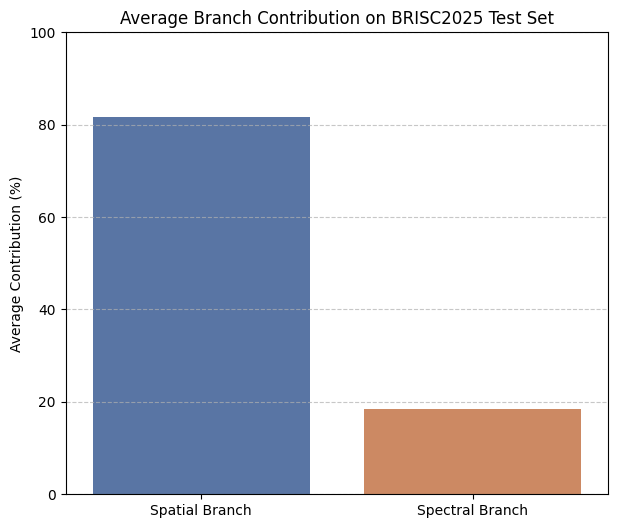


--- Generating Combined Distribution Plot (All Filled) ---


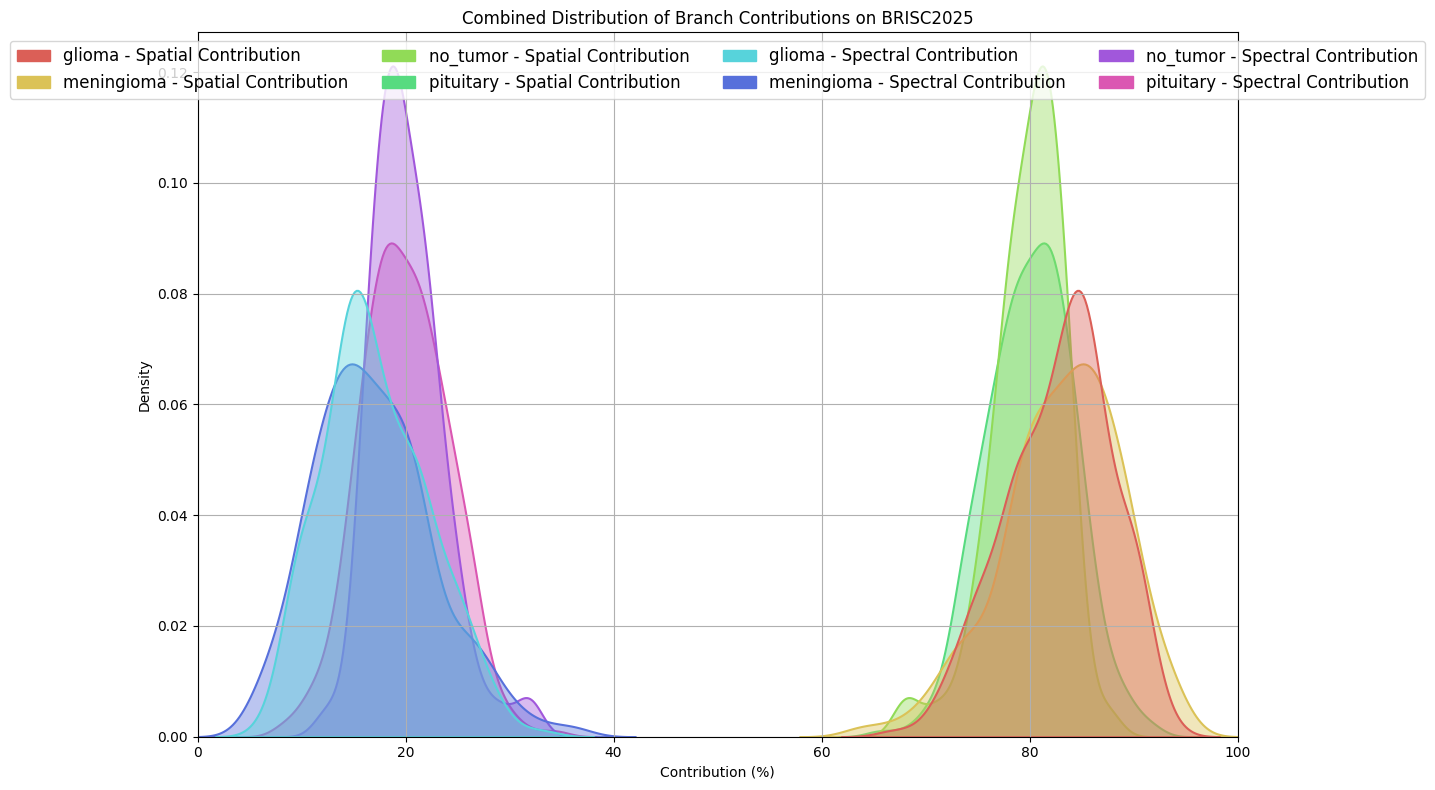


--- Generating Per-Class Distribution Plots ---


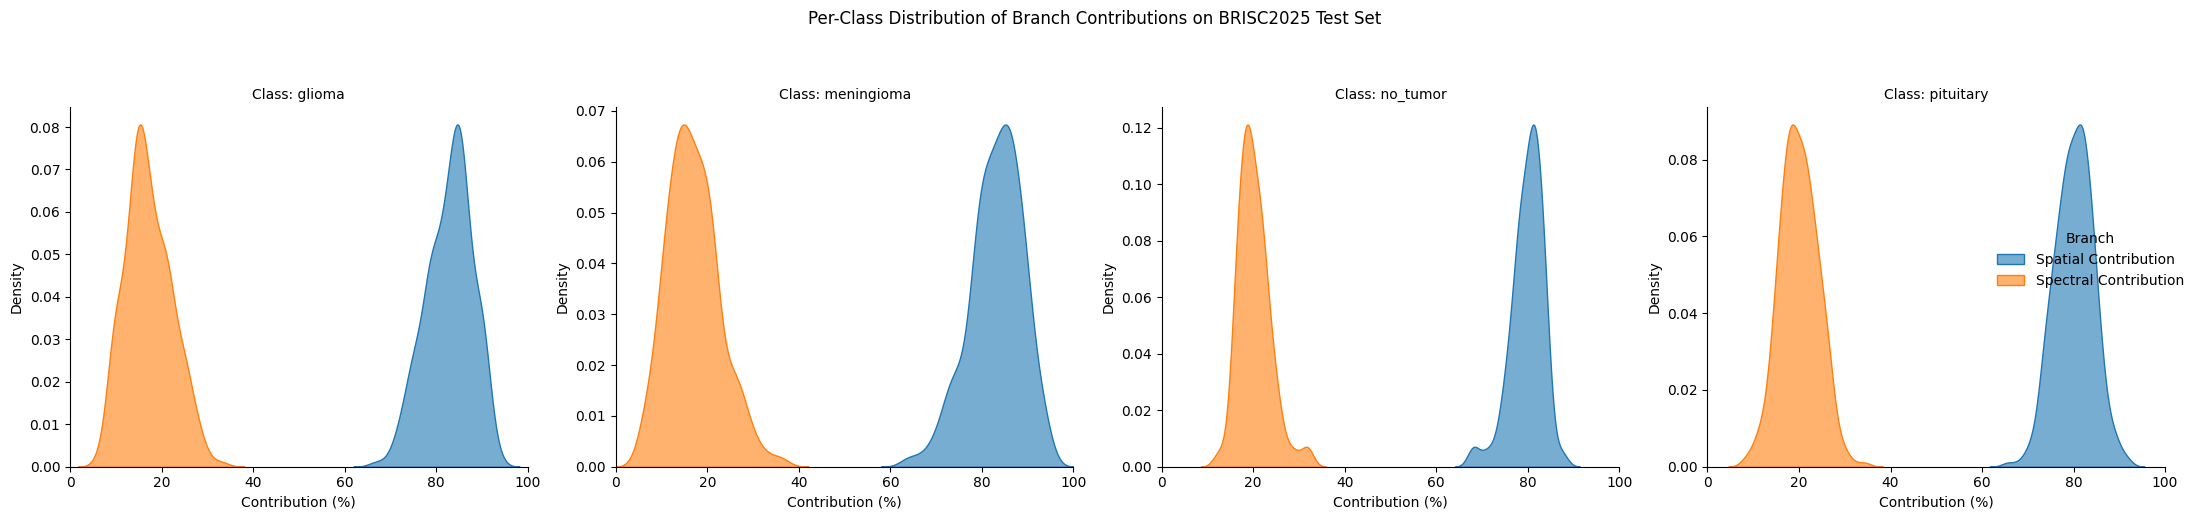

In [ ]:
# ==============================================================================
# BLOCK 5: ANALYSIS AND VISUALIZATION
# ==============================================================================

# --- Calculating L2 Norms and Contributions ---
spatial_norms = np.linalg.norm(spatial_vectors, axis=1)
spectral_norms = np.linalg.norm(spectral_vectors, axis=1)
total_norms = spatial_norms + spectral_norms; total_norms[total_norms == 0] = 1e-6
spatial_contribution = (spatial_norms / total_norms) * 100
spectral_contribution = (spectral_norms / total_norms) * 100

# --- Preparing DataFrame for all analyses ---
df_contrib = pd.DataFrame({
    'Spatial Contribution': spatial_contribution,
    'Spectral Contribution': spectral_contribution,
    'True Label': [CLASS_NAMES[i] for i in y_test.flatten()]
})

# Melted DataFrame for distribution plots
df_melted = df_contrib.melt(
    id_vars=['True Label'],
    value_vars=['Spatial Contribution', 'Spectral Contribution'],
    var_name='Branch',
    value_name='Contribution (%)'
)

# --- Reporting Overall and Per-Class Average Contributions ---
avg_spatial_contrib = df_contrib['Spatial Contribution'].mean()
avg_spectral_contrib = df_contrib['Spectral Contribution'].mean()
print("\n" + "="*60); print(f"    BRANCH CONTRIBUTION ANALYSIS ({DATASET_TO_EVALUATE})"); print("="*60)
print(f"Overall Average Spatial Branch Contribution:  {avg_spatial_contrib:.2f}%")
print(f"Overall Average Spectral Branch Contribution: {avg_spectral_contrib:.2f}%")
print("-" * 60)
print("Per-Class Average Contributions:")
class_wise_avg = df_contrib.groupby('True Label').mean()
print(class_wise_avg.to_string(float_format="%.2f%%"))
print("="*60 + "\n")

# --- Visualizing the Results ---

# 1. Bar Chart for the Overall Average
plt.figure(figsize=(7, 6))
palette = sns.color_palette("deep")
sns.barplot(x=['Spatial Branch', 'Spectral Branch'], y=[avg_spatial_contrib, avg_spectral_contrib], palette=[palette[0], palette[1]])
plt.ylabel("Average Contribution (%)")
plt.title(f"Average Branch Contribution on {DATASET_TO_EVALUATE} Test Set")
plt.ylim(0, 100); plt.grid(axis='y', linestyle='--', alpha=0.7); plt.show()

# --- COMBINED DISTRIBUTION PLOT ---
import matplotlib.patches as mpatches

print("\n--- Generating Combined Distribution Plot (All Filled) ---")
plt.figure(figsize=(14, 8))
ax = plt.gca() # Get the current axes

# Creating a unique color for each combination of "True Label" and "Branch"
num_labels = len(df_melted['True Label'].unique())
num_branches = len(df_melted['Branch'].unique())
palette = sns.color_palette("hls", n_colors=num_labels * num_branches)

# Creating a new column that combines the class and branch for the hue mapping
df_melted['Hue Category'] = df_melted['True Label'].str.cat(df_melted['Branch'], sep=' - ')

# Plotting the KDE using the new combined category for the color
sns.kdeplot(
    data=df_melted,
    x="Contribution (%)",
    hue="Hue Category",
    fill=True,
    alpha=0.4,
    linewidth=1.5,
    common_norm=False,
    palette=palette,
    ax=ax,
    legend=False
)

# Getting the unique categories and their corresponding colors
hue_categories = df_melted['Hue Category'].unique()
colors = palette[:len(hue_categories)]

# Creating a list of "patches" for the legend
legend_patches = [mpatches.Patch(color=color, label=label)
                  for label, color in zip(hue_categories, colors)]

# Creating the legend manually and placing it INSIDE the grid at the top center
plt.legend(
    handles=legend_patches,
    #title='Class - Branch',
    loc='upper center',
    ncol=min(4, len(CLASS_NAMES)),
    fontsize='large'
)

plt.title(f"Combined Distribution of Branch Contributions on {DATASET_TO_EVALUATE}")
plt.grid(True)
plt.xlim(0, 100)
plt.tight_layout()
plt.show()

# --- CLASS-WISE SEPARATE PLOTS ---
# A "melted" DataFrame for the FacetGrid plot
print("\n--- Generating Per-Class Distribution Plots ---")
df_melted = df_contrib.melt(
    id_vars=['True Label'],
    value_vars=['Spatial Contribution', 'Spectral Contribution'],
    var_name='Branch',
    value_name='Contribution (%)'
)
# 4. Creating the separate, per-class distribution plots
g = sns.FacetGrid(
    df_melted, col="True Label", hue="Branch", col_wrap=min(4, len(CLASS_NAMES)),
    height=5, sharex=True, sharey=False
)
g.map(sns.kdeplot, "Contribution (%)", fill=True, alpha=0.6, common_norm=False)
g.add_legend()
g.fig.suptitle(f'Per-Class Distribution of Branch Contributions on {DATASET_TO_EVALUATE} Test Set', y=1.03)
g.set(xlim=(0, 100))
g.set_titles("Class: {col_name}")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

## **Using the proposed *Balanced Contribution Score***


    BALANCED BRANCH CONTRIBUTION ANALYSIS (BRISC2025)
Average Spatial Branch Contribution:  29.52%
Average Spectral Branch Contribution: 70.48%
------------------------------------------------------------
Per-Class Average Contributions:
            Spatial Contribution (%)  Spectral Contribution (%)
True Label                                                     
glioma                        31.35%                     68.65%
meningioma                    32.11%                     67.89%
no_tumor                      26.35%                     73.65%
pituitary                     26.91%                     73.09%



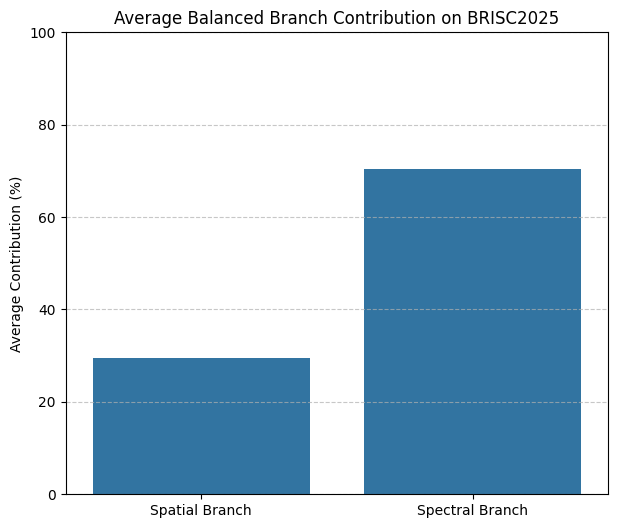


--- Generating Combined Distribution Plot (All Filled) ---


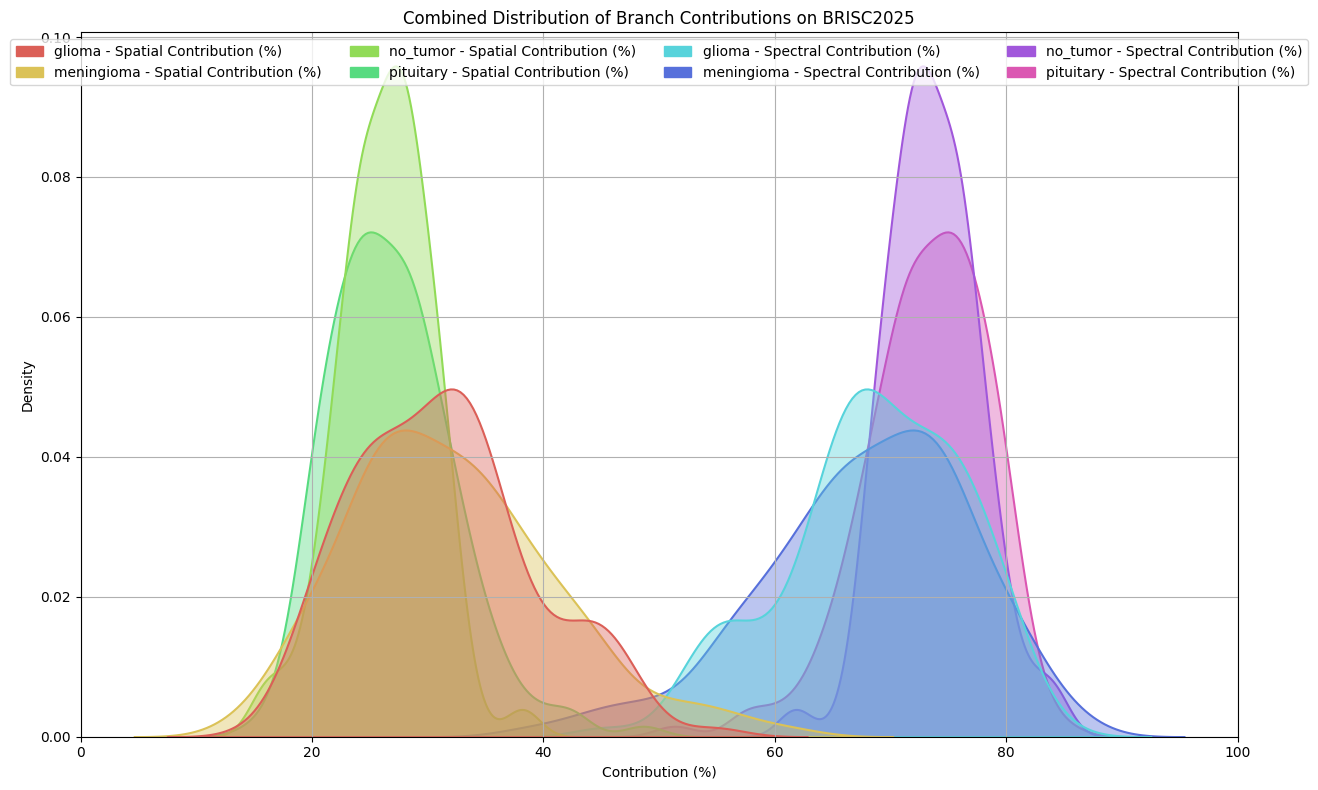

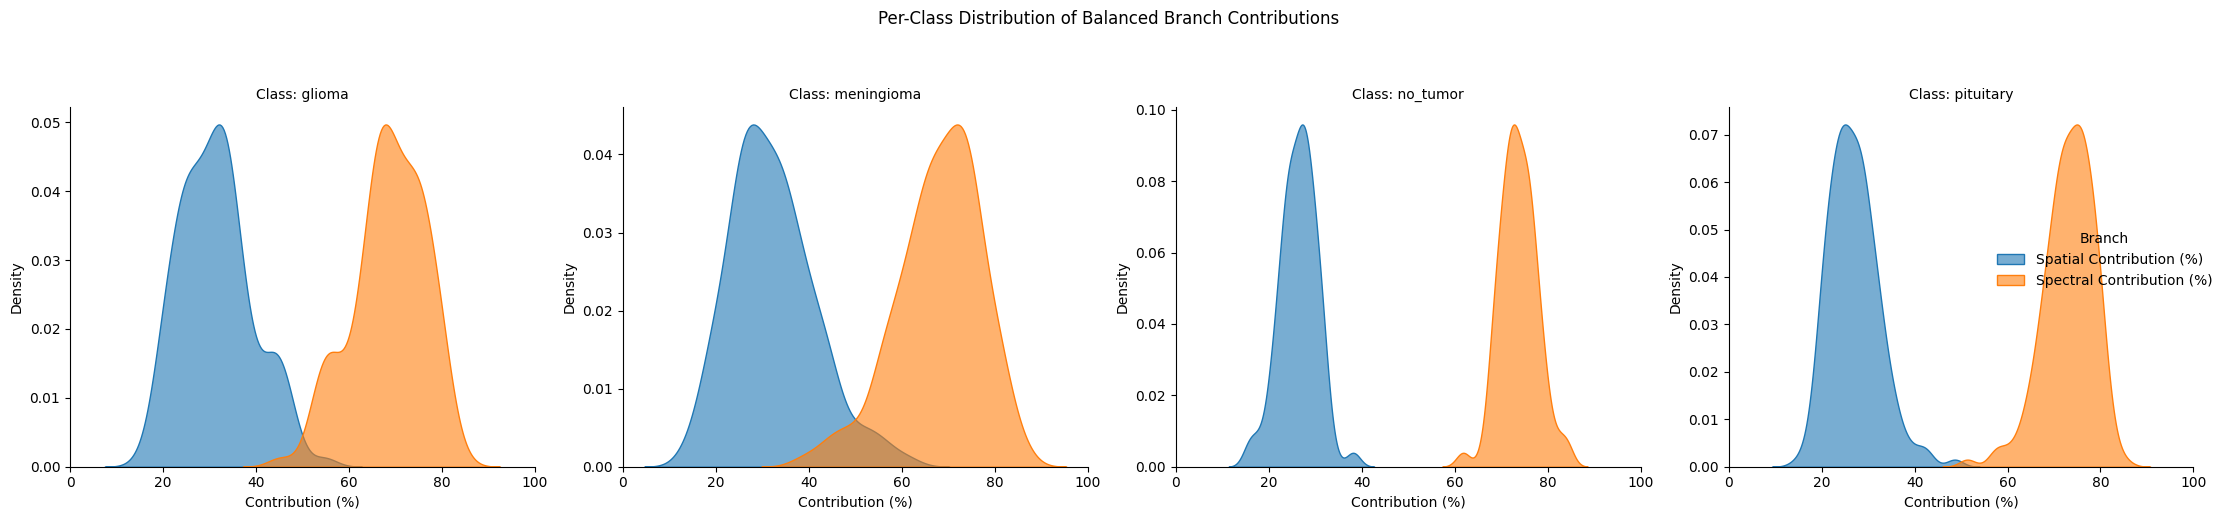

In [ ]:
# --- 1. Calculating Component Metrics ---
# Total Magnitude (L2 Norm)
spatial_total_mag = np.linalg.norm(spatial_vectors, axis=1)
spectral_total_mag = np.linalg.norm(spectral_vectors, axis=1)

# Per-Feature Magnitude
spatial_dim = spatial_vectors.shape[1]
spectral_dim = spectral_vectors.shape[1]
spatial_per_feature_mag = spatial_total_mag / spatial_dim
spectral_per_feature_mag = spectral_total_mag / spectral_dim

# --- Calculating the Balanced Contribution Score ---
# Geometric Mean of the two magnitudes
spatial_score = np.sqrt(spatial_total_mag * spatial_per_feature_mag)
spectral_score = np.sqrt(spectral_total_mag * spectral_per_feature_mag)

# --- Calculating Percentage Contributions based on the new score ---
total_score = spatial_score + spectral_score
total_score[total_score == 0] = 1e-6 # Avoid division by zero

spatial_contribution_pct = (spatial_score / total_score) * 100
spectral_contribution_pct = (spectral_score / total_score) * 100

# --- Reporting the Averages ---
avg_spatial_contrib = np.mean(spatial_contribution_pct)
avg_spectral_contrib = np.mean(spectral_contribution_pct)

print("\n" + "="*60)
print(f"    BALANCED BRANCH CONTRIBUTION ANALYSIS ({DATASET_TO_EVALUATE})")
print("="*60)
print(f"Average Spatial Branch Contribution:  {avg_spatial_contrib:.2f}%")
print(f"Average Spectral Branch Contribution: {avg_spectral_contrib:.2f}%")
print("-" * 60)

# --- Per-Class Reporting ---
df_contrib = pd.DataFrame({
    'Spatial Contribution (%)': spatial_contribution_pct,
    'Spectral Contribution (%)': spectral_contribution_pct,
    'True Label': [CLASS_NAMES[i] for i in y_test.flatten()]
})
print("Per-Class Average Contributions:")
class_wise_avg = df_contrib.groupby('True Label').mean()
print(class_wise_avg.to_string(float_format="%.2f%%"))
print("="*60 + "\n")

# Melted DataFrame for distribution plots
df_melted = df_contrib.melt(
    id_vars=['True Label'],
    value_vars=['Spatial Contribution (%)', 'Spectral Contribution (%)'],
    var_name='Branch',
    value_name='Contribution (%)'
)

# --- Visualizing the Results ---

# Bar Chart for the Average
plt.figure(figsize=(7, 6))
sns.barplot(x=['Spatial Branch', 'Spectral Branch'], y=[avg_spatial_contrib, avg_spectral_contrib])
plt.ylabel("Average Contribution (%)")
plt.title(f"Average Balanced Branch Contribution on {DATASET_TO_EVALUATE}")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# --- COMBINED DISTRIBUTION PLOT ---
import matplotlib.patches as mpatches

print("\n--- Generating Combined Distribution Plot (All Filled) ---")
plt.figure(figsize=(14, 8))
ax = plt.gca()

# Creating a unique color for each combination of "True Label" and "Branch"
num_labels = len(df_melted['True Label'].unique())
num_branches = len(df_melted['Branch'].unique())
palette = sns.color_palette("hls", n_colors=num_labels * num_branches)

# Creating a new column that combines the class and branch for the hue mapping
df_melted['Hue Category'] = df_melted['True Label'].str.cat(df_melted['Branch'], sep=' - ')

# Plotting the KDE using the new combined category for the color
sns.kdeplot(
    data=df_melted,
    x="Contribution (%)",
    hue="Hue Category",
    fill=True,
    alpha=0.4,
    linewidth=1.5,
    common_norm=False,
    palette=palette,
    ax=ax,
    legend=False
)

# Getting the unique categories and their corresponding colors
hue_categories = df_melted['Hue Category'].unique()
colors = palette[:len(hue_categories)] # Use the same colors sns used

# Creating a list of "patches" for the legend
legend_patches = [mpatches.Patch(color=color, label=label)
                  for label, color in zip(hue_categories, colors)]

# Creating the legend manually and placing it INSIDE the grid at the top center
plt.legend(
    handles=legend_patches,
    #title='Class - Branch',
    loc='upper center',
    ncol=min(4, len(CLASS_NAMES)),
    fontsize='medium'
)

plt.title(f"Combined Distribution of Branch Contributions on {DATASET_TO_EVALUATE}")
plt.grid(True)
plt.xlim(0, 100)
plt.tight_layout()
plt.show()

# Per-Class Distribution Plot
df_melted = df_contrib.melt(
    id_vars=['True Label'],
    value_vars=['Spatial Contribution (%)', 'Spectral Contribution (%)'],
    var_name='Branch',
    value_name='Contribution (%)'
)
g = sns.FacetGrid(df_melted, col="True Label", hue="Branch", col_wrap=min(4, len(CLASS_NAMES)), height=5, sharex=True, sharey=False)
g.map(sns.kdeplot, "Contribution (%)", fill=True, alpha=0.6, common_norm=False)
g.add_legend()
g.fig.suptitle(f'Per-Class Distribution of Balanced Branch Contributions', y=1.03)
g.set(xlim=(0, 100))
g.set_titles("Class: {col_name}")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()